# **Desafio IHM Stefanini - 03 - NeuralProphet**

Será feito um modelo NeuralProphet para prever a série temporal da variável `% Silica Concentrate`. Serão feitos 5 modelos:
1. Modelo multivariado com todas as variáveis;
2. Modelo multivariado apenas com as variáveis selecionados na etapa de preparação;
3. Modelo multivariado com todas as variáveis, mas excluindo a variável `% Iron Concentrate`;
4. Modelo multivariado apenas com as variáveis selecionados na etapa de preparação e excluindo a variável `% Iron Concentrate`;
5. Modelo univariado.

Em todos os casos, será feito a previsão para um horizonte de 24 períodos, ou seja, 24 horas a frente.

## **Carregando as bibliotecas**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

D:\Python_Venvs\neuralprophet\vienv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## **Configurações do notebook**

In [2]:
# Configuração gerais
%matplotlib inline
sns.set(style='white')
pd.set_option('display.max_columns', None)

# Random seed
RANDOM_SEED = 1

# Configurações do NeuralProphet
set_log_level("ERROR") # Exibir log apenas se houver algum erro
set_random_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings("ignore")

## **Carregando os dados**

In [3]:
df = pd.read_csv("dados_ihm_stefanini/flotation_hour.csv")

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,295.096,306.4,251.232529,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
1,2017-03-10 02:00:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,295.096,306.4,249.909494,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2,2017-03-10 03:00:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,295.096,306.4,250.242161,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
3,2017-03-10 04:00:00,55.2,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,295.096,306.4,249.825122,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
4,2017-03-10 05:00:00,55.2,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,295.096,306.4,250.249600,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          4415 non-null   datetime64[ns]
 1   % Iron Feed                   4415 non-null   float64       
 2   % Silica Feed                 4415 non-null   float64       
 3   Starch Flow                   4415 non-null   float64       
 4   Amina Flow                    4415 non-null   float64       
 5   Ore Pulp Flow                 4415 non-null   float64       
 6   Ore Pulp pH                   4415 non-null   float64       
 7   Ore Pulp Density              4415 non-null   float64       
 8   Flotation Column 01 Air Flow  4415 non-null   float64       
 9   Flotation Column 02 Air Flow  4415 non-null   float64       
 10  Flotation Column 03 Air Flow  4415 non-null   float64       
 11  Flotation Column 04 Air Flow  

## **Funções necessárias**

In [7]:
# Métricas
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics_dict['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics_dict['MAPE'] = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100
    return metrics_dict

## **Ajustes necessários para o modelo NeuralProphet**

**Renomeando as colunas `date` e `% Silica Concentrate`:**

In [8]:
df.rename(columns={"date": "ds", "% Silica Concentrate": "y"}, inplace=True)

### **Separando os dados em treino e teste**

**Treino:**

In [9]:
treino = df.drop(df.index[-24:])
treino

,ds,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,y
0,2017-03-10 01:00:00,55.20,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,295.096000,306.400000,251.232529,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
1,2017-03-10 02:00:00,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,295.096000,306.400000,249.909494,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2,2017-03-10 03:00:00,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,295.096000,306.400000,250.242161,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
3,2017-03-10 04:00:00,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,295.096000,306.400000,249.825122,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
4,2017-03-10 05:00:00,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,295.096000,306.400000,250.249600,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4386,2017-09-08 19:00:00,59.55,8.45,1814.082561,286.948050,378.794775,9.224923,1.596176,299.937494,300.281400,299.930189,299.929867,300.045589,299.907800,300.612778,399.246644,499.504078,399.884889,403.851878,400.782472,400.266183,402.725244,65.12,1.33
4387,2017-09-08 20:00:00,59.55,8.45,2751.251532,306.293311,380.472236,9.387055,1.630635,299.836139,300.033742,300.003611,299.913328,300.002856,300.073050,300.030389,400.178172,498.873272,399.506600,400.187917,400.958233,400.416839,400.626439,64.91,1.50
4388,2017-09-08 21:00:00,59.55,8.45,1557.087077,300.106875,377.982556,9.500313,1.631130,299.882483,300.264511,299.929856,299.893272,299.882983,299.432156,299.994811,405.193939,502.707611,406.744867,403.466583,400.435589,400.730467,402.128683,63.91,2.94
4389,2017-09-08 22:00:00,59.55,8.45,2796.314864,284.769595,377.172188,9.752432,1.610417,300.044350,299.575717,299.945356,299.905850,299.735056,299.839067,300.091883,421.995161,499.303681,432.606683,393.067961,398.634122,399.848311,399.132417,63.54,4.10


**Teste:**

In [10]:
teste = df[-24:].reset_index(drop=True)
teste

,ds,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,y
0,2017-09-09 00:00:00,59.55,8.45,2926.600829,489.406744,380.761944,9.654977,1.655980,299.824122,299.655028,299.875678,299.907217,299.834867,299.965233,299.746917,399.708189,497.237556,400.154611,399.308767,400.392872,399.830311,398.490011,63.00,4.18
1,2017-09-09 01:00:00,49.56,24.20,2044.172218,477.120444,380.884986,9.618139,1.624229,299.906928,299.673750,300.025150,299.933200,299.986756,300.045628,300.763156,399.304811,498.109178,399.790989,400.914261,401.113000,399.647133,400.393506,63.47,3.24
2,2017-09-09 02:00:00,49.56,24.20,1549.602767,393.205100,379.456711,9.227681,1.557234,299.931333,300.462744,299.970978,299.919117,300.177928,299.517067,299.214833,400.484483,497.200450,399.585522,395.856211,399.833417,399.686828,399.060811,64.86,2.34
3,2017-09-09 03:00:00,49.56,24.20,2565.138464,365.719417,379.711595,9.158911,1.536460,299.822594,299.747856,299.868217,299.903778,299.993372,300.250628,299.799744,400.144317,499.156167,399.709472,402.762550,401.223800,399.778122,400.563972,64.03,3.07
4,2017-09-09 04:00:00,49.56,24.20,3112.085250,497.625356,379.951077,9.429278,1.674363,299.922317,299.763067,299.963972,299.901339,299.636789,300.072667,300.665750,399.893378,499.402494,399.903489,399.245172,400.171856,399.902689,400.554867,63.69,3.12
5,2017-09-09 05:00:00,49.56,24.20,1516.844243,502.239056,380.650353,9.696310,1.657818,299.939317,299.846478,299.919594,299.896106,299.913817,299.754911,300.944667,399.355583,497.898572,399.471167,398.424339,401.618111,399.516872,398.913206,63.49,3.26
6,2017-09-09 06:00:00,49.56,24.20,2200.388426,416.533433,380.653842,9.665631,1.548030,299.926428,299.909189,299.881478,299.947156,299.932856,300.273433,299.582944,399.125033,497.775628,399.870017,398.829000,399.900233,400.219183,398.769206,65.00,1.93
7,2017-09-09 07:00:00,54.63,12.90,3260.616611,555.557256,411.258554,9.535045,1.649501,300.116600,300.010683,299.950478,299.958794,300.079183,300.527972,300.563000,399.936950,502.032228,399.838567,402.260050,398.257172,400.057122,401.394289,64.17,2.23
8,2017-09-09 08:00:00,54.63,12.90,3673.921111,582.045314,413.685193,9.644717,1.651699,299.994789,300.013144,299.919567,299.916439,299.741683,299.539206,299.881772,399.413894,501.466511,398.527189,400.643422,399.362000,400.516222,401.502011,64.40,2.15
9,2017-09-09 09:00:00,54.63,12.90,3840.586889,586.408950,415.232145,9.765653,1.640704,300.039483,299.637367,299.994789,299.913706,299.953611,300.466533,301.029300,398.997778,498.230917,401.166506,401.423856,398.713889,398.460006,398.872917,65.26,2.30


## **Modelo NeuralProphet - Multivariado com todas as variáveis**

### **Ajuste dos hiperparâmetros com Optuna**

Os hiperparâmetros a serem ajustados serão:
- growth;
- n_forecasts;
- learning_rate;

Os hiperparâmetros relacionados à sazonalidade e tendência não serão ajustados, pois pelas análises de tendência e sazonalidad , não nota-se ambas na série temporal.

In [11]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['off', 'linear', 'discontinuous'])
    n_forecasts = trial.suggest_int('n_forecasts', 1, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)

    # Instaciando o modelo
    m = NeuralProphet(growth=growth, n_forecasts=n_forecasts, learning_rate=learning_rate)
    m.add_future_regressor("% Iron Feed")
    m.add_future_regressor("% Silica Feed")
    m.add_future_regressor("Starch Flow")
    m.add_future_regressor("Amina Flow")
    m.add_future_regressor("Ore Pulp Flow")
    m.add_future_regressor("Ore Pulp pH")
    m.add_future_regressor("Ore Pulp Density")
    m.add_future_regressor("Flotation Column 01 Air Flow")
    m.add_future_regressor("Flotation Column 02 Air Flow")
    m.add_future_regressor("Flotation Column 03 Air Flow")
    m.add_future_regressor("Flotation Column 04 Air Flow")
    m.add_future_regressor("Flotation Column 05 Air Flow")
    m.add_future_regressor("Flotation Column 06 Air Flow")
    m.add_future_regressor("Flotation Column 07 Air Flow")
    m.add_future_regressor("Flotation Column 01 Level")
    m.add_future_regressor("Flotation Column 02 Level")
    m.add_future_regressor("Flotation Column 03 Level")
    m.add_future_regressor("Flotation Column 04 Level")
    m.add_future_regressor("Flotation Column 05 Level")
    m.add_future_regressor("Flotation Column 06 Level")
    m.add_future_regressor("Flotation Column 07 Level")
    m.add_future_regressor("% Iron Concentrate")

    # Treinando o modelo
    m.fit(treino.drop(treino.index[-24:]), freq="h")

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True)
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat1.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [12]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 14:21:37,103] A new study created in memory with name: no-name-5e6809a2-ec63-4146-85ab-e8c7a9dd954a


Epoch 70: 100%|█| 70/70 [00:00<00:00, 248.41it/s, loss=0.0244, v_num=1531, MAE=0.445, RMSE=0.588, Loss=0.0259, RegLoss=
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.79it/s]

[I 2024-10-19 14:21:59,200] Trial 0 finished with value: 18.275462954241338 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.1468412152280313}. Best is trial 0 with value: 18.275462954241338.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 269.45it/s, loss=0.0266, v_num=1532, MAE=0.445, RMSE=0.590, Loss=0.0262, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.55it/s]

[I 2024-10-19 14:22:18,550] Trial 1 finished with value: 17.970750587168226 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5388628523299566}. Best is trial 1 with value: 17.970750587168226.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 232.12it/s, loss=0.0261, v_num=1533, MAE=0.446, RMSE=0.589, Loss=0.0259, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.21it/s]

[I 2024-10-19 14:22:38,473] Trial 2 finished with value: 17.5577060559786 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.02748485443860637}. Best is trial 2 with value: 17.5577060559786.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 266.95it/s, loss=0.0286, v_num=1534, MAE=0.471, RMSE=0.613, Loss=0.0277, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.39it/s]

[I 2024-10-19 14:22:56,622] Trial 3 finished with value: 21.05727628809294 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.1981816789359703}. Best is trial 2 with value: 17.5577060559786.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 247.38it/s, loss=0.025, v_num=1535, MAE=0.452, RMSE=0.596, Loss=0.0265, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.29it/s]

[I 2024-10-19 14:23:17,160] Trial 4 finished with value: 21.10905952883312 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8764015133808087}. Best is trial 2 with value: 17.5577060559786.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 281.13it/s, loss=0.0271, v_num=1536, MAE=0.481, RMSE=0.623, Loss=0.0287, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.01it/s]

[I 2024-10-19 14:23:34,740] Trial 5 finished with value: 19.68246577523749 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8781546891790702}. Best is trial 2 with value: 17.5577060559786.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 261.37it/s, loss=0.0271, v_num=1537, MAE=0.451, RMSE=0.596, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.42it/s]

[I 2024-10-19 14:23:54,429] Trial 6 finished with value: 17.9748935520934 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6919079262390783}. Best is trial 2 with value: 17.5577060559786.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 245.93it/s, loss=0.0281, v_num=1538, MAE=0.451, RMSE=0.596, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.61it/s]

[I 2024-10-19 14:24:14,776] Trial 7 finished with value: 17.327826013148197 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.750169300513473}. Best is trial 7 with value: 17.327826013148197.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 277.22it/s, loss=0.0285, v_num=1539, MAE=0.472, RMSE=0.612, Loss=0.0277, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.83it/s]

[I 2024-10-19 14:24:33,141] Trial 8 finished with value: 22.38703117579932 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.10331568397698426}. Best is trial 7 with value: 17.327826013148197.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 251.63it/s, loss=0.025, v_num=1540, MAE=0.443, RMSE=0.587, Loss=0.0257, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.45it/s]

[I 2024-10-19 14:24:55,449] Trial 9 finished with value: 17.72101814094944 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.13011556926106585}. Best is trial 7 with value: 17.327826013148197.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 264.11it/s, loss=0.026, v_num=1541, MAE=0.443, RMSE=0.590, Loss=0.0259, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.16it/s]

[I 2024-10-19 14:25:14,429] Trial 10 finished with value: 18.48081123835481 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.39221508547571643}. Best is trial 7 with value: 17.327826013148197.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 262.20it/s, loss=0.0285, v_num=1542, MAE=0.454, RMSE=0.598, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.45it/s]

[I 2024-10-19 14:25:34,178] Trial 11 finished with value: 16.697319581037405 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.666929783130762}. Best is trial 11 with value: 16.697319581037405.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 222.56it/s, loss=0.0261, v_num=1543, MAE=0.455, RMSE=0.600, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.14it/s]

[I 2024-10-19 14:25:54,168] Trial 12 finished with value: 16.161881156010345 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.674661753436846}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 246.01it/s, loss=0.0275, v_num=1544, MAE=0.448, RMSE=0.593, Loss=0.0265, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.43it/s]

[I 2024-10-19 14:26:16,620] Trial 13 finished with value: 20.271595868971122 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.5260905811474292}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 252.82it/s, loss=0.0262, v_num=1545, MAE=0.455, RMSE=0.598, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.42it/s]

[I 2024-10-19 14:26:37,533] Trial 14 finished with value: 18.68129934637902 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.6687771058406179}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 251.36it/s, loss=0.0268, v_num=1546, MAE=0.456, RMSE=0.601, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.89it/s]

[I 2024-10-19 14:26:57,924] Trial 15 finished with value: 17.986196699458425 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.9830916988542835}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 229.75it/s, loss=0.0274, v_num=1547, MAE=0.454, RMSE=0.596, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.53it/s]

[I 2024-10-19 14:27:19,264] Trial 16 finished with value: 18.800425581240475 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.39042260680219204}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.19it/s, loss=0.0269, v_num=1548, MAE=0.452, RMSE=0.597, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.56it/s]

[I 2024-10-19 14:27:40,272] Trial 17 finished with value: 19.100455107477664 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.6099498563586022}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 248.60it/s, loss=0.0259, v_num=1549, MAE=0.445, RMSE=0.591, Loss=0.0261, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.26it/s]

[I 2024-10-19 14:28:00,796] Trial 18 finished with value: 17.293076540862472 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.3866529596564806}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 291.90it/s, loss=0.0297, v_num=1550, MAE=0.481, RMSE=0.621, Loss=0.0285, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.13it/s]

[I 2024-10-19 14:28:18,557] Trial 19 finished with value: 20.605416066613632 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.7955854692897645}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 260.80it/s, loss=0.0265, v_num=1551, MAE=0.438, RMSE=0.586, Loss=0.0257, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.33it/s]

[I 2024-10-19 14:28:38,071] Trial 20 finished with value: 17.103275145302092 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.3146906402220837}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.72it/s, loss=0.0268, v_num=1552, MAE=0.440, RMSE=0.584, Loss=0.0256, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.96it/s]

[I 2024-10-19 14:28:57,749] Trial 21 finished with value: 17.230866038595813 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.2951100716194945}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 260.23it/s, loss=0.0261, v_num=1553, MAE=0.446, RMSE=0.594, Loss=0.0263, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.01it/s]

[I 2024-10-19 14:29:17,767] Trial 22 finished with value: 17.497970030573114 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.6051809470762106}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 259.02it/s, loss=0.0267, v_num=1554, MAE=0.452, RMSE=0.596, Loss=0.0265, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.21it/s]

[I 2024-10-19 14:29:37,459] Trial 23 finished with value: 21.75568771391768 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.45065725300287685}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.44it/s, loss=0.0254, v_num=1555, MAE=0.441, RMSE=0.584, Loss=0.0256, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.51it/s]

[I 2024-10-19 14:29:57,514] Trial 24 finished with value: 16.890065820068063 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.2869379143016385}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 251.11it/s, loss=0.026, v_num=1556, MAE=0.457, RMSE=0.599, Loss=0.0268, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 191.32it/s]

[I 2024-10-19 14:30:17,861] Trial 25 finished with value: 18.893355427235203 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.6006389910740493}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 259.69it/s, loss=0.0258, v_num=1557, MAE=0.466, RMSE=0.609, Loss=0.028, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 14:30:37,281] Trial 26 finished with value: 18.1694960458729 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.8193917461443929}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 247.79it/s, loss=0.0258, v_num=1558, MAE=0.443, RMSE=0.586, Loss=0.0258, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.59it/s]

[I 2024-10-19 14:30:56,471] Trial 27 finished with value: 17.43208697556269 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.24372553178435863}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 293.70it/s, loss=0.0284, v_num=1559, MAE=0.479, RMSE=0.621, Loss=0.0284, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.96it/s]

[I 2024-10-19 14:31:14,179] Trial 28 finished with value: 20.539249563891882 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.4859770915609072}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.47it/s, loss=0.0287, v_num=1560, MAE=0.455, RMSE=0.600, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.64it/s]

[I 2024-10-19 14:31:33,968] Trial 29 finished with value: 18.54091141730788 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7065122039179651}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.13it/s, loss=0.0252, v_num=1561, MAE=0.456, RMSE=0.599, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.91it/s]

[I 2024-10-19 14:31:53,792] Trial 30 finished with value: 19.37407693049625 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.9650332561948013}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 265.18it/s, loss=0.0263, v_num=1562, MAE=0.443, RMSE=0.588, Loss=0.0259, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.63it/s]

[I 2024-10-19 14:32:13,779] Trial 31 finished with value: 16.537538673877222 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.30477572530646785}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 268.34it/s, loss=0.0244, v_num=1563, MAE=0.442, RMSE=0.587, Loss=0.0259, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.30it/s]

[I 2024-10-19 14:32:32,944] Trial 32 finished with value: 16.314116498267104 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.30728356134724866}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 266.85it/s, loss=0.0278, v_num=1564, MAE=0.446, RMSE=0.592, Loss=0.0262, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.05it/s]

[I 2024-10-19 14:32:52,338] Trial 33 finished with value: 16.90431647617896 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.5725048110348608}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 267.53it/s, loss=0.218, v_num=1565, MAE=1.720, RMSE=2.170, Loss=0.217, RegLoss=0.
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.63it/s]

[I 2024-10-19 14:33:11,464] Trial 34 finished with value: 69.28846290795724 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.0002573745959087437}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 265.58it/s, loss=0.0233, v_num=1566, MAE=0.444, RMSE=0.587, Loss=0.0258, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.48it/s]

[I 2024-10-19 14:33:30,602] Trial 35 finished with value: 19.221518599747093 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.44120691765987885}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 257.82it/s, loss=0.0258, v_num=1567, MAE=0.447, RMSE=0.589, Loss=0.0259, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.00it/s]

[I 2024-10-19 14:33:50,515] Trial 36 finished with value: 17.159550665018592 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.18942127226297806}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 225.67it/s, loss=0.0268, v_num=1568, MAE=0.451, RMSE=0.596, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.97it/s]

[I 2024-10-19 14:34:10,743] Trial 37 finished with value: 18.909984411842544 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.6556976184524165}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 277.47it/s, loss=0.0272, v_num=1569, MAE=0.473, RMSE=0.614, Loss=0.0279, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.18it/s]

[I 2024-10-19 14:34:29,875] Trial 38 finished with value: 19.966769854330657 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.3349763806534497}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.92it/s, loss=0.0248, v_num=1570, MAE=0.436, RMSE=0.582, Loss=0.0254, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.15it/s]

[I 2024-10-19 14:34:51,642] Trial 39 finished with value: 17.519410308367924 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.09338210019512244}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 228.43it/s, loss=0.0255, v_num=1571, MAE=0.455, RMSE=0.596, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.22it/s]

[I 2024-10-19 14:35:13,347] Trial 40 finished with value: 16.305063228993674 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7447143686518751}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 156.39it/s, loss=0.0269, v_num=1572, MAE=0.456, RMSE=0.601, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.64it/s]

[I 2024-10-19 14:35:38,342] Trial 41 finished with value: 17.99761545644128 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7970360344202065}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 244.82it/s, loss=0.027, v_num=1573, MAE=0.452, RMSE=0.593, Loss=0.0264, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.04it/s]

[I 2024-10-19 14:36:02,228] Trial 42 finished with value: 16.23223597213494 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7334052208122054}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 158.81it/s, loss=0.0271, v_num=1574, MAE=0.457, RMSE=0.599, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.58it/s]

[I 2024-10-19 14:36:29,246] Trial 43 finished with value: 16.439879369840067 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.7525556945344989}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 189.84it/s, loss=0.0278, v_num=1575, MAE=0.458, RMSE=0.602, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.77it/s]

[I 2024-10-19 14:36:57,877] Trial 44 finished with value: 16.447215872840758 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7397129189256306}. Best is trial 12 with value: 16.161881156010345.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 181.69it/s, loss=0.0255, v_num=1576, MAE=0.455, RMSE=0.599, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.11it/s]

[I 2024-10-19 14:37:25,900] Trial 45 finished with value: 14.660496847633683 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.8602420224460372}. Best is trial 45 with value: 14.660496847633683.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 186.03it/s, loss=0.027, v_num=1577, MAE=0.457, RMSE=0.601, Loss=0.0271, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.52it/s]

[I 2024-10-19 14:37:53,133] Trial 46 finished with value: 19.79572110368495 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8832881751469043}. Best is trial 45 with value: 14.660496847633683.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 170.63it/s, loss=0.0276, v_num=1578, MAE=0.464, RMSE=0.606, Loss=0.0274, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.86it/s]

[I 2024-10-19 14:38:20,461] Trial 47 finished with value: 17.234918044196135 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.9178727794366229}. Best is trial 45 with value: 14.660496847633683.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 155.43it/s, loss=0.0285, v_num=1579, MAE=0.464, RMSE=0.607, Loss=0.0274, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.26it/s]

[I 2024-10-19 14:38:50,720] Trial 48 finished with value: 21.74872666328786 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8367544433775762}. Best is trial 45 with value: 14.660496847633683.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 198.29it/s, loss=0.0279, v_num=1580, MAE=0.453, RMSE=0.595, Loss=0.0265, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.52it/s]

[I 2024-10-19 14:39:20,881] Trial 49 finished with value: 16.491496759799286 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7369817721812415}. Best is trial 45 with value: 14.660496847633683.


In [13]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 14.660496847633683
Melhores parâmetros: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.8602420224460372}


### **Treinando o modelo com os hiperparâmetros ajustados**

In [14]:
m = NeuralProphet(
    growth=melhores_parametros['growth'],
    n_forecasts=melhores_parametros['n_forecasts'],
    learning_rate=melhores_parametros['learning_rate']
)

m.add_future_regressor("% Iron Feed")
m.add_future_regressor("% Silica Feed")
m.add_future_regressor("Starch Flow")
m.add_future_regressor("Amina Flow")
m.add_future_regressor("Ore Pulp Flow")
m.add_future_regressor("Ore Pulp pH")
m.add_future_regressor("Ore Pulp Density")
m.add_future_regressor("Flotation Column 01 Air Flow")
m.add_future_regressor("Flotation Column 02 Air Flow")
m.add_future_regressor("Flotation Column 03 Air Flow")
m.add_future_regressor("Flotation Column 04 Air Flow")
m.add_future_regressor("Flotation Column 05 Air Flow")
m.add_future_regressor("Flotation Column 06 Air Flow")
m.add_future_regressor("Flotation Column 07 Air Flow")
m.add_future_regressor("Flotation Column 01 Level")
m.add_future_regressor("Flotation Column 02 Level")
m.add_future_regressor("Flotation Column 03 Level")
m.add_future_regressor("Flotation Column 04 Level")
m.add_future_regressor("Flotation Column 05 Level")
m.add_future_regressor("Flotation Column 06 Level")
m.add_future_regressor("Flotation Column 07 Level")
m.add_future_regressor("% Iron Concentrate")

m.fit(treino, freq='h')

Epoch 70: 100%|█| 70/70 [00:00<00:00, 219.15it/s, loss=0.0258, v_num=1581, MAE=0.453, RMSE=0.596, Loss=0.0266, RegLoss=


,MAE,RMSE,Loss,RegLoss,epoch
0,1.390521,1.727568,0.167452,0.0,0
1,0.683088,0.860343,0.053168,0.0,1
2,0.694878,0.861868,0.053793,0.0,2
3,0.795971,0.989537,0.068971,0.0,3
4,0.811971,1.002719,0.070179,0.0,4
...,...,...,...,...,...
65,0.456351,0.599543,0.026872,0.0,65
66,0.455889,0.600278,0.027036,0.0,66
67,0.450018,0.596724,0.026551,0.0,67
68,0.455507,0.598277,0.026743,0.0,68


### **Avaliando o modelo**

In [15]:
# Previsões
y_pred = m.predict(teste)

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.12it/s]


In [16]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat1.values)

{'RMSE': 0.5799369017694525,
 'MAE': 0.4632054859399795,
 'MAPE': 21.308401559535575}

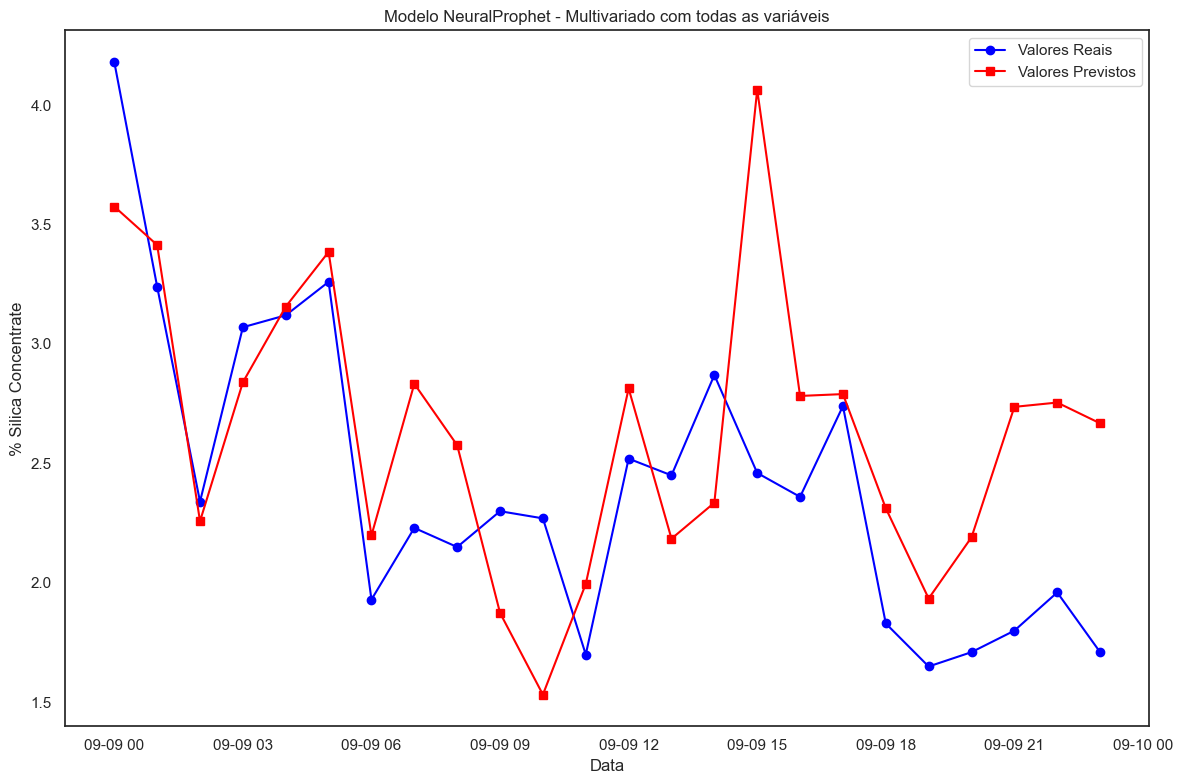

In [17]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker='o', color="blue")
plt.plot(y_pred.ds, y_pred.yhat1.values, label="Valores Previstos", marker='s', color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo NeuralProphet - Multivariado com todas as variáveis")
plt.legend()

plt.tight_layout()

## **Modelo NeuralProphet - Multivariado com as variáveis selecionadas**

### **Ajuste dos hiperparâmetros com Optuna**

In [18]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['off', 'linear', 'discontinuous'])
    n_forecasts = trial.suggest_int('n_forecasts', 1, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)

    # Instaciando o modelo
    m = NeuralProphet(growth=growth, n_forecasts=n_forecasts, learning_rate=learning_rate)
    m.add_future_regressor("Amina Flow")
    m.add_future_regressor("Ore Pulp pH")
    m.add_future_regressor("Flotation Column 01 Air Flow")
    m.add_future_regressor("Flotation Column 02 Air Flow")
    m.add_future_regressor("Flotation Column 03 Air Flow")
    m.add_future_regressor("Flotation Column 04 Level")
    m.add_future_regressor("Flotation Column 05 Level")
    m.add_future_regressor("Flotation Column 06 Level")
    m.add_future_regressor("Flotation Column 07 Level")
    m.add_future_regressor("% Iron Concentrate")

    # Treinando o modelo
    m.fit(treino.drop(treino.index[-24:]).loc[:, ["ds", "Amina Flow", "Ore Pulp pH", 
                                                  "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                                  "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level", 
                                                  "% Iron Concentrate", "y"]], freq="h")

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True).loc[:, ["ds", "Amina Flow", "Ore Pulp pH", 
                                                  "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                                  "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level", 
                                                  "% Iron Concentrate", "y"]]
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat1.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [19]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 14:39:47,165] A new study created in memory with name: no-name-c718dafe-7bc9-4e64-9c54-38af5619f05e


Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.45it/s, loss=0.0262, v_num=1582, MAE=0.444, RMSE=0.589, Loss=0.026, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.01it/s]

[I 2024-10-19 14:40:09,421] Trial 0 finished with value: 17.243065996060906 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.1468412152280313}. Best is trial 0 with value: 17.243065996060906.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 243.78it/s, loss=0.0271, v_num=1583, MAE=0.443, RMSE=0.593, Loss=0.0263, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.60it/s]

[I 2024-10-19 14:40:30,582] Trial 1 finished with value: 17.030888936510948 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5388628523299566}. Best is trial 1 with value: 17.030888936510948.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 229.54it/s, loss=0.027, v_num=1584, MAE=0.457, RMSE=0.601, Loss=0.0269, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.92it/s]

[I 2024-10-19 14:40:53,022] Trial 2 finished with value: 17.710095536312842 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.02748485443860637}. Best is trial 1 with value: 17.030888936510948.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 262.61it/s, loss=0.0277, v_num=1585, MAE=0.481, RMSE=0.622, Loss=0.0284, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.32it/s]

[I 2024-10-19 14:41:12,249] Trial 3 finished with value: 22.295895960245016 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.1981816789359703}. Best is trial 1 with value: 17.030888936510948.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 220.76it/s, loss=0.0284, v_num=1586, MAE=0.459, RMSE=0.606, Loss=0.0275, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.51it/s]

[I 2024-10-19 14:41:34,019] Trial 4 finished with value: 16.524717779300317 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8764015133808087}. Best is trial 4 with value: 16.524717779300317.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 269.66it/s, loss=0.0298, v_num=1587, MAE=0.492, RMSE=0.635, Loss=0.0298, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.87it/s]

[I 2024-10-19 14:41:53,061] Trial 5 finished with value: 21.501430224432795 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8781546891790702}. Best is trial 4 with value: 16.524717779300317.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.60it/s, loss=0.0287, v_num=1588, MAE=0.450, RMSE=0.598, Loss=0.027, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 232.51it/s]

[I 2024-10-19 14:42:14,242] Trial 6 finished with value: 15.164582286790404 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6919079262390783}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.40it/s, loss=0.0257, v_num=1589, MAE=0.453, RMSE=0.599, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.37it/s]

[I 2024-10-19 14:42:35,461] Trial 7 finished with value: 18.026797273634564 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.750169300513473}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 242.97it/s, loss=0.0286, v_num=1590, MAE=0.480, RMSE=0.622, Loss=0.0284, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.44it/s]

[I 2024-10-19 14:42:54,371] Trial 8 finished with value: 23.142147945920897 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.10331568397698426}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.62it/s, loss=0.0269, v_num=1591, MAE=0.446, RMSE=0.592, Loss=0.0263, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.07it/s]

[I 2024-10-19 14:43:16,088] Trial 9 finished with value: 17.977924350663844 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.13011556926106585}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.04it/s, loss=0.0244, v_num=1592, MAE=0.446, RMSE=0.594, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.98it/s]

[I 2024-10-19 14:43:37,428] Trial 10 finished with value: 16.993820265973916 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.5373269199794267}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.43it/s, loss=0.0283, v_num=1593, MAE=0.459, RMSE=0.607, Loss=0.0276, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.15it/s]

[I 2024-10-19 14:43:59,146] Trial 11 finished with value: 19.829236980529565 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.9873677079333998}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 238.10it/s, loss=0.0277, v_num=1594, MAE=0.451, RMSE=0.599, Loss=0.027, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.76it/s]

[I 2024-10-19 14:44:20,564] Trial 12 finished with value: 19.368747330028484 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.733334588399394}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.93it/s, loss=0.0288, v_num=1595, MAE=0.448, RMSE=0.595, Loss=0.0265, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.19it/s]

[I 2024-10-19 14:44:42,161] Trial 13 finished with value: 18.3692910325059 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.7023759910894738}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 227.79it/s, loss=0.0281, v_num=1596, MAE=0.448, RMSE=0.594, Loss=0.0264, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.47it/s]

[I 2024-10-19 14:45:04,114] Trial 14 finished with value: 17.479946269193867 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.3304565322038435}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.96it/s, loss=0.0267, v_num=1597, MAE=0.455, RMSE=0.603, Loss=0.0272, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.21it/s]

[I 2024-10-19 14:45:25,917] Trial 15 finished with value: 16.72023450829507 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.8736880310372855}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 231.07it/s, loss=0.0266, v_num=1598, MAE=0.447, RMSE=0.593, Loss=0.0264, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.82it/s]

[I 2024-10-19 14:45:47,624] Trial 16 finished with value: 18.468794048775376 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.39042260680219204}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 237.53it/s, loss=0.0279, v_num=1599, MAE=0.458, RMSE=0.604, Loss=0.0272, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.36it/s]

[I 2024-10-19 14:46:09,934] Trial 17 finished with value: 20.05739855379933 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.6752777047862322}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 229.65it/s, loss=0.0267, v_num=1600, MAE=0.455, RMSE=0.604, Loss=0.0274, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.59it/s]

[I 2024-10-19 14:46:31,218] Trial 18 finished with value: 17.351310632747598 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.9802595492801396}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 271.83it/s, loss=0.0283, v_num=1601, MAE=0.485, RMSE=0.627, Loss=0.0288, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 241.15it/s]

[I 2024-10-19 14:46:50,275] Trial 19 finished with value: 25.985289168047228 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.6235334546489046}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 212.81it/s, loss=0.0269, v_num=1602, MAE=0.450, RMSE=0.597, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 270.41it/s]

[I 2024-10-19 14:47:12,039] Trial 20 finished with value: 19.118196476491725 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.8170663749219281}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 230.98it/s, loss=0.0277, v_num=1603, MAE=0.452, RMSE=0.601, Loss=0.0269, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.90it/s]

[I 2024-10-19 14:47:33,132] Trial 21 finished with value: 16.555683570072617 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.851514836865611}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.74it/s, loss=0.0279, v_num=1604, MAE=0.459, RMSE=0.605, Loss=0.0275, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 222.91it/s]

[I 2024-10-19 14:47:54,414] Trial 22 finished with value: 22.207766299580403 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.8379868050256732}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.09it/s, loss=0.0263, v_num=1605, MAE=0.446, RMSE=0.596, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.46it/s]

[I 2024-10-19 14:48:15,702] Trial 23 finished with value: 16.50582624826156 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6044354595536107}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.24it/s, loss=0.0251, v_num=1606, MAE=0.451, RMSE=0.597, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.64it/s]

[I 2024-10-19 14:48:36,923] Trial 24 finished with value: 18.240662580820523 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.6072672263102233}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.87it/s, loss=0.0264, v_num=1607, MAE=0.449, RMSE=0.595, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.44it/s]

[I 2024-10-19 14:48:58,688] Trial 25 finished with value: 17.844205155657384 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.39982829067526626}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 244.71it/s, loss=0.0271, v_num=1608, MAE=0.447, RMSE=0.596, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 209.10it/s]

[I 2024-10-19 14:49:19,862] Trial 26 finished with value: 19.65747562197743 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.4707750674127935}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.92it/s, loss=0.0268, v_num=1609, MAE=0.448, RMSE=0.598, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.28it/s]

[I 2024-10-19 14:49:41,131] Trial 27 finished with value: 19.34472499342694 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.6043893312194375}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 261.29it/s, loss=0.0289, v_num=1610, MAE=0.487, RMSE=0.630, Loss=0.0291, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 222.04it/s]

[I 2024-10-19 14:50:00,037] Trial 28 finished with value: 18.017882254827335 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.924452704233389}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 215.02it/s, loss=0.0258, v_num=1611, MAE=0.453, RMSE=0.597, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.04it/s]

[I 2024-10-19 14:50:22,043] Trial 29 finished with value: 17.009530662796756 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.7669558583995426}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.64it/s, loss=0.0283, v_num=1612, MAE=0.457, RMSE=0.604, Loss=0.0273, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.01it/s]

[I 2024-10-19 14:50:43,977] Trial 30 finished with value: 17.244712651729866 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.6784740051836292}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.63it/s, loss=0.0282, v_num=1613, MAE=0.458, RMSE=0.605, Loss=0.0275, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.31it/s]

[I 2024-10-19 14:51:04,958] Trial 31 finished with value: 17.792793157381055 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.7892917412230972}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 244.12it/s, loss=0.027, v_num=1614, MAE=0.456, RMSE=0.603, Loss=0.0273, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.86it/s]

[I 2024-10-19 14:51:26,087] Trial 32 finished with value: 17.895907262254713 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.9133500547603289}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.14it/s, loss=0.0278, v_num=1615, MAE=0.451, RMSE=0.597, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.28it/s]

[I 2024-10-19 14:51:46,959] Trial 33 finished with value: 21.494523928360685 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.6463555294117422}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.86it/s, loss=0.0259, v_num=1616, MAE=0.448, RMSE=0.595, Loss=0.0265, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.75it/s]

[I 2024-10-19 14:52:07,980] Trial 34 finished with value: 22.031573081129885 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.5009332946835328}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 224.89it/s, loss=0.0278, v_num=1617, MAE=0.450, RMSE=0.598, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.21it/s]

[I 2024-10-19 14:52:29,059] Trial 35 finished with value: 18.827007540252986 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.5666605741830605}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 243.35it/s, loss=0.0248, v_num=1618, MAE=0.453, RMSE=0.600, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.85it/s]

[I 2024-10-19 14:52:50,244] Trial 36 finished with value: 23.256941334264685 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.8212975246697167}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 272.06it/s, loss=0.0295, v_num=1619, MAE=0.487, RMSE=0.631, Loss=0.0293, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.21it/s]

[I 2024-10-19 14:53:09,263] Trial 37 finished with value: 21.5612783928361 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.9055166575564372}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.65it/s, loss=0.0285, v_num=1620, MAE=0.454, RMSE=0.601, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.46it/s]

[I 2024-10-19 14:53:30,756] Trial 38 finished with value: 15.888188108163664 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.7270087672337959}. Best is trial 6 with value: 15.164582286790404.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.82it/s, loss=0.027, v_num=1621, MAE=0.453, RMSE=0.599, Loss=0.0268, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.94it/s]

[I 2024-10-19 14:53:52,568] Trial 39 finished with value: 14.079566060476175 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.7033439174280611}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.28it/s, loss=0.0256, v_num=1622, MAE=0.453, RMSE=0.599, Loss=0.0268, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.55it/s]

[I 2024-10-19 14:54:14,441] Trial 40 finished with value: 17.62532685443794 and parameters: {'growth': 'linear', 'n_forecasts': 1, 'learning_rate': 0.5551327147223302}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.56it/s, loss=0.0243, v_num=1623, MAE=0.454, RMSE=0.601, Loss=0.027, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.32it/s]

[I 2024-10-19 14:54:36,113] Trial 41 finished with value: 20.052019222620135 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.6944491609771523}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.43it/s, loss=0.0263, v_num=1624, MAE=0.456, RMSE=0.604, Loss=0.0273, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.73it/s]

[I 2024-10-19 14:54:57,948] Trial 42 finished with value: 16.053005278210644 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.6400948177174146}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.30it/s, loss=0.0255, v_num=1625, MAE=0.455, RMSE=0.602, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.41it/s]

[I 2024-10-19 14:55:19,808] Trial 43 finished with value: 18.843108978329205 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.4808754212902857}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.67it/s, loss=0.026, v_num=1626, MAE=0.453, RMSE=0.600, Loss=0.0271, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.34it/s]

[I 2024-10-19 14:55:41,451] Trial 44 finished with value: 16.60531257926866 and parameters: {'growth': 'linear', 'n_forecasts': 1, 'learning_rate': 0.7518089975865775}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 213.25it/s, loss=0.0289, v_num=1627, MAE=0.459, RMSE=0.605, Loss=0.0274, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.90it/s]

[I 2024-10-19 14:56:03,193] Trial 45 finished with value: 19.741192703126544 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.7202651403058139}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 231.07it/s, loss=0.0261, v_num=1628, MAE=0.454, RMSE=0.601, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.04it/s]

[I 2024-10-19 14:56:25,215] Trial 46 finished with value: 18.322697172382053 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.6419263366417438}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 216.60it/s, loss=0.0269, v_num=1629, MAE=0.451, RMSE=0.596, Loss=0.0267, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.78it/s]

[I 2024-10-19 14:56:47,291] Trial 47 finished with value: 17.816951653582205 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.5993713022855607}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 237.30it/s, loss=0.0277, v_num=1630, MAE=0.455, RMSE=0.601, Loss=0.0271, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.95it/s]

[I 2024-10-19 14:57:09,271] Trial 48 finished with value: 15.54279579928022 and parameters: {'growth': 'linear', 'n_forecasts': 1, 'learning_rate': 0.530280735024222}. Best is trial 39 with value: 14.079566060476175.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.72it/s, loss=0.0271, v_num=1631, MAE=0.449, RMSE=0.595, Loss=0.0266, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.44it/s]

[I 2024-10-19 14:57:31,003] Trial 49 finished with value: 16.376427423684397 and parameters: {'growth': 'linear', 'n_forecasts': 1, 'learning_rate': 0.42863565319611224}. Best is trial 39 with value: 14.079566060476175.


In [20]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 14.079566060476175
Melhores parâmetros: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.7033439174280611}


### **Treinando o modelo com os hiperparâmetros ajustados**

In [21]:
m = NeuralProphet(
    growth=melhores_parametros['growth'],
    n_forecasts=melhores_parametros['n_forecasts'],
    learning_rate=melhores_parametros['learning_rate']
)

m.add_future_regressor("Amina Flow")
m.add_future_regressor("Ore Pulp pH")
m.add_future_regressor("Flotation Column 01 Air Flow")
m.add_future_regressor("Flotation Column 02 Air Flow")
m.add_future_regressor("Flotation Column 03 Air Flow")
m.add_future_regressor("Flotation Column 04 Level")
m.add_future_regressor("Flotation Column 05 Level")
m.add_future_regressor("Flotation Column 06 Level")
m.add_future_regressor("Flotation Column 07 Level")
m.add_future_regressor("% Iron Concentrate")

m.fit(treino.loc[:, ["ds", "Amina Flow", "Ore Pulp pH", 
                     "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                     "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level",
                     "% Iron Concentrate", "y"]], freq='h')

Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.29it/s, loss=0.0275, v_num=1632, MAE=0.455, RMSE=0.601, Loss=0.0271, RegLoss=


,MAE,RMSE,Loss,RegLoss,epoch
0,1.151790,1.466883,0.126656,0.0,0
1,0.604347,0.770764,0.043217,0.0,1
2,0.633046,0.795311,0.046265,0.0,2
3,0.663286,0.834822,0.049852,0.0,3
4,0.688234,0.867495,0.054723,0.0,4
...,...,...,...,...,...
65,0.458937,0.602231,0.027183,0.0,65
66,0.458460,0.601709,0.027146,0.0,66
67,0.455795,0.603031,0.027270,0.0,67
68,0.451948,0.599611,0.026963,0.0,68


### **Avaliando o modelo**

In [22]:
# Previsões
y_pred = m.predict(teste.loc[:, ["ds", "Amina Flow", "Ore Pulp pH",
                                 "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                 "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level",
                                 "% Iron Concentrate", "y"]])

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.28it/s]


In [23]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat1.values)

{'RMSE': 0.6012558148162701,
 'MAE': 0.45194764733314513,
 'MAPE': 21.053653182611217}

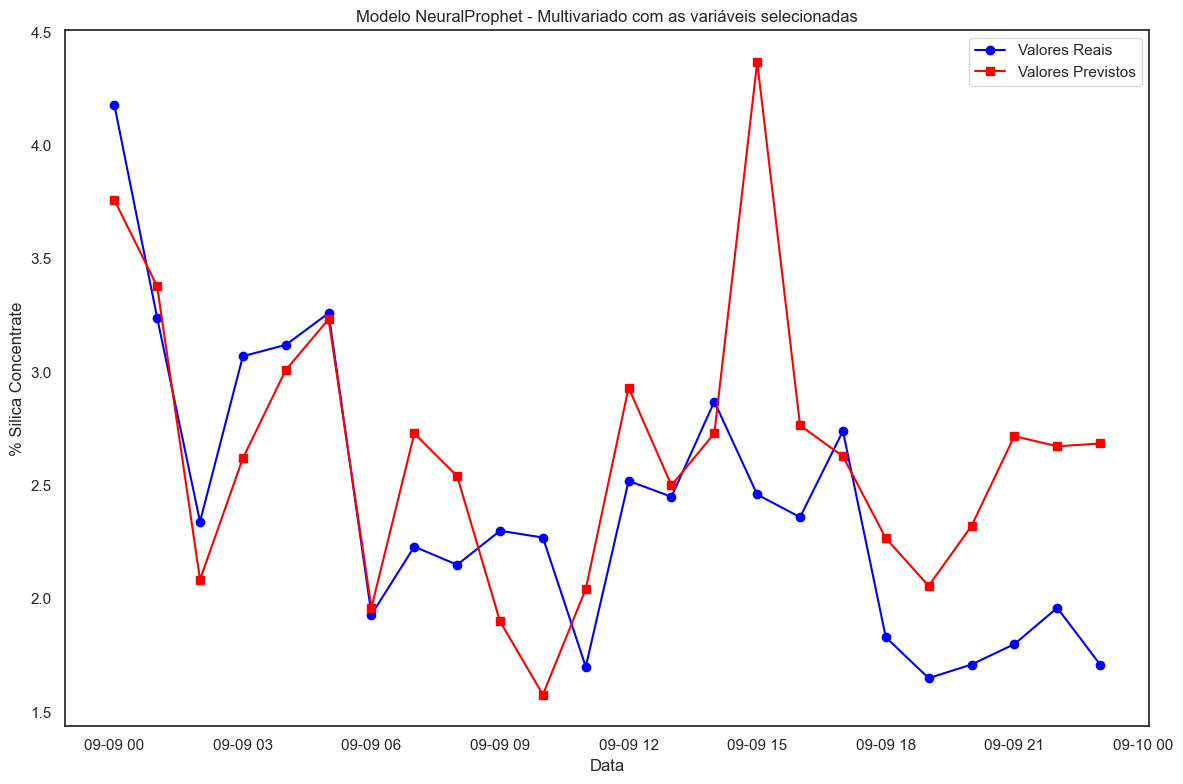

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker='o', color="blue")
plt.plot(y_pred.ds, y_pred.yhat1.values, label="Valores Previstos", marker='s', color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo NeuralProphet - Multivariado com as variáveis selecionadas")
plt.legend()

plt.tight_layout()

## **Modelo NeuralProphet - Multivariado com todas as variáveis, excluindo apenas `% Iron Concentrate`**

### **Ajuste dos hiperparâmetros com Optuna**

In [25]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['off', 'linear', 'discontinuous'])
    n_forecasts = trial.suggest_int('n_forecasts', 1, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)

    # Instaciando o modelo
    m = NeuralProphet(growth=growth, n_forecasts=n_forecasts, learning_rate=learning_rate)
    m.add_future_regressor("% Iron Feed")
    m.add_future_regressor("% Silica Feed")
    m.add_future_regressor("Starch Flow")
    m.add_future_regressor("Amina Flow")
    m.add_future_regressor("Ore Pulp Flow")
    m.add_future_regressor("Ore Pulp pH")
    m.add_future_regressor("Ore Pulp Density")
    m.add_future_regressor("Flotation Column 01 Air Flow")
    m.add_future_regressor("Flotation Column 02 Air Flow")
    m.add_future_regressor("Flotation Column 03 Air Flow")
    m.add_future_regressor("Flotation Column 04 Air Flow")
    m.add_future_regressor("Flotation Column 05 Air Flow")
    m.add_future_regressor("Flotation Column 06 Air Flow")
    m.add_future_regressor("Flotation Column 07 Air Flow")
    m.add_future_regressor("Flotation Column 01 Level")
    m.add_future_regressor("Flotation Column 02 Level")
    m.add_future_regressor("Flotation Column 03 Level")
    m.add_future_regressor("Flotation Column 04 Level")
    m.add_future_regressor("Flotation Column 05 Level")
    m.add_future_regressor("Flotation Column 06 Level")
    m.add_future_regressor("Flotation Column 07 Level")

    # Treinando o modelo
    m.fit(treino.drop(treino.index[-24:]).drop(columns=["% Iron Concentrate"]), freq="h")

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True).drop(columns=["% Iron Concentrate"])
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat1.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [26]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 14:57:53,514] A new study created in memory with name: no-name-e3a09533-5f17-4325-8303-cf503d1f59f6


Epoch 70: 100%|█| 70/70 [00:00<00:00, 232.26it/s, loss=0.0627, v_num=1633, MAE=0.765, RMSE=0.994, Loss=0.0644, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.46it/s]

[I 2024-10-19 14:58:15,839] Trial 0 finished with value: 35.749221907232624 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.1468412152280313}. Best is trial 0 with value: 35.749221907232624.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 230.68it/s, loss=0.0672, v_num=1634, MAE=0.756, RMSE=0.989, Loss=0.0643, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.96it/s]

[I 2024-10-19 14:58:37,521] Trial 1 finished with value: 43.120340856860565 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5388628523299566}. Best is trial 0 with value: 35.749221907232624.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 227.56it/s, loss=0.0665, v_num=1635, MAE=0.768, RMSE=0.991, Loss=0.0643, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.84it/s]

[I 2024-10-19 14:58:59,475] Trial 2 finished with value: 38.5280463731766 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.02748485443860637}. Best is trial 0 with value: 35.749221907232624.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 264.35it/s, loss=0.0699, v_num=1636, MAE=0.801, RMSE=1.030, Loss=0.0681, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.70it/s]

[I 2024-10-19 14:59:18,850] Trial 3 finished with value: 34.77974318676115 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.1981816789359703}. Best is trial 3 with value: 34.77974318676115.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 210.63it/s, loss=0.0664, v_num=1637, MAE=0.780, RMSE=1.010, Loss=0.0665, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.15it/s]

[I 2024-10-19 14:59:41,729] Trial 4 finished with value: 26.706275120845792 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8764015133808087}. Best is trial 4 with value: 26.706275120845792.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 255.50it/s, loss=0.0682, v_num=1638, MAE=0.814, RMSE=1.050, Loss=0.0703, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.08it/s]

[I 2024-10-19 15:00:01,135] Trial 5 finished with value: 37.481587845213966 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8781546891790702}. Best is trial 4 with value: 26.706275120845792.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 237.10it/s, loss=0.0627, v_num=1639, MAE=0.764, RMSE=0.998, Loss=0.0652, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.17it/s]

[I 2024-10-19 15:00:23,596] Trial 6 finished with value: 33.02851789140175 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6919079262390783}. Best is trial 4 with value: 26.706275120845792.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 242.84it/s, loss=0.0674, v_num=1640, MAE=0.762, RMSE=1.000, Loss=0.0654, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.22it/s]

[I 2024-10-19 15:00:45,141] Trial 7 finished with value: 25.743155545864344 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.750169300513473}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.58it/s, loss=0.0653, v_num=1641, MAE=0.798, RMSE=1.030, Loss=0.0678, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.48it/s]

[I 2024-10-19 15:01:04,403] Trial 8 finished with value: 31.819487089575333 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.10331568397698426}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.59it/s, loss=0.0684, v_num=1642, MAE=0.764, RMSE=0.995, Loss=0.0642, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.57it/s]

[I 2024-10-19 15:01:26,516] Trial 9 finished with value: 37.32221047601656 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.13011556926106585}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 242.28it/s, loss=0.065, v_num=1643, MAE=0.751, RMSE=0.984, Loss=0.0634, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 15:01:48,019] Trial 10 finished with value: 28.201561703537497 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.39221508547571643}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.90it/s, loss=0.0624, v_num=1644, MAE=0.784, RMSE=1.010, Loss=0.0667, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.77it/s]

[I 2024-10-19 15:02:10,485] Trial 11 finished with value: 36.26527917405466 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.9873677079333998}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 238.24it/s, loss=0.0644, v_num=1645, MAE=0.750, RMSE=0.985, Loss=0.0637, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.90it/s]

[I 2024-10-19 15:02:31,827] Trial 12 finished with value: 34.389404255097496 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.7539084656141023}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.93it/s, loss=0.0657, v_num=1646, MAE=0.755, RMSE=0.987, Loss=0.0641, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 140.52it/s]

[I 2024-10-19 15:02:52,931] Trial 13 finished with value: 40.159022404110765 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.7106538967729619}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.73it/s, loss=0.068, v_num=1647, MAE=0.772, RMSE=1.000, Loss=0.0656, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.21it/s]

[I 2024-10-19 15:03:15,380] Trial 14 finished with value: 42.31011831533949 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.5429358859459983}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.70it/s, loss=0.0652, v_num=1648, MAE=0.759, RMSE=0.993, Loss=0.0647, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.85it/s]

[I 2024-10-19 15:03:37,143] Trial 15 finished with value: 36.446125764601604 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.8532749442683365}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 228.97it/s, loss=0.0636, v_num=1649, MAE=0.782, RMSE=1.010, Loss=0.0665, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.25it/s]

[I 2024-10-19 15:03:59,187] Trial 16 finished with value: 40.9227673097206 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.9766635553905451}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 228.88it/s, loss=0.068, v_num=1650, MAE=0.776, RMSE=1.010, Loss=0.0658, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.44it/s]

[I 2024-10-19 15:04:21,122] Trial 17 finished with value: 37.973851203387255 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.628578608911246}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 220.03it/s, loss=0.064, v_num=1651, MAE=0.747, RMSE=0.981, Loss=0.0633, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.98it/s]

[I 2024-10-19 15:04:42,369] Trial 18 finished with value: 27.15580485483825 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.3866529596564806}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 255.95it/s, loss=0.0682, v_num=1652, MAE=0.809, RMSE=1.040, Loss=0.069, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.58it/s]

[I 2024-10-19 15:05:01,647] Trial 19 finished with value: 36.758710172270455 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.8384290341577796}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.19it/s, loss=0.0635, v_num=1653, MAE=0.774, RMSE=1.010, Loss=0.0663, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.37it/s]

[I 2024-10-19 15:05:23,000] Trial 20 finished with value: 31.948509048309287 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.7860385516330011}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.22it/s, loss=0.0624, v_num=1654, MAE=0.749, RMSE=0.984, Loss=0.0633, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.62it/s]

[I 2024-10-19 15:05:44,207] Trial 21 finished with value: 31.091871991271375 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.33307719402308644}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 213.81it/s, loss=0.0638, v_num=1655, MAE=0.752, RMSE=0.986, Loss=0.0637, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.46it/s]

[I 2024-10-19 15:06:05,610] Trial 22 finished with value: 31.050844172035553 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.41246489168895856}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 238.26it/s, loss=0.0631, v_num=1656, MAE=0.750, RMSE=0.980, Loss=0.063, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.46it/s]

[I 2024-10-19 15:06:26,818] Trial 23 finished with value: 34.45988846569806 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.26489329715349863}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 245.23it/s, loss=0.0652, v_num=1657, MAE=0.762, RMSE=0.994, Loss=0.0647, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.34it/s]

[I 2024-10-19 15:06:48,132] Trial 24 finished with value: 40.11569342140306 and parameters: {'growth': 'discontinuous', 'n_forecasts': 6, 'learning_rate': 0.6159287565737024}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.51it/s, loss=0.0678, v_num=1658, MAE=0.770, RMSE=0.999, Loss=0.0652, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.45it/s]

[I 2024-10-19 15:07:09,864] Trial 25 finished with value: 39.00694798328507 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.47885444323794013}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.21it/s, loss=0.0672, v_num=1659, MAE=0.755, RMSE=0.994, Loss=0.0645, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.30it/s]

[I 2024-10-19 15:07:31,043] Trial 26 finished with value: 39.79819564736935 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.631394477382782}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.01it/s, loss=0.0685, v_num=1660, MAE=0.775, RMSE=1.000, Loss=0.0664, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.96it/s]

[I 2024-10-19 15:07:52,186] Trial 27 finished with value: 31.523543030498374 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.9248346288784111}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 270.51it/s, loss=0.0671, v_num=1661, MAE=0.802, RMSE=1.030, Loss=0.0682, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.32it/s]

[I 2024-10-19 15:08:11,302] Trial 28 finished with value: 29.920787216160267 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.4441241881814174}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.08it/s, loss=0.0642, v_num=1662, MAE=0.769, RMSE=0.999, Loss=0.0649, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.19it/s]

[I 2024-10-19 15:08:33,252] Trial 29 finished with value: 33.36911902314503 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.332325903807467}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 230.81it/s, loss=0.0658, v_num=1663, MAE=0.771, RMSE=1.000, Loss=0.0655, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.96it/s]

[I 2024-10-19 15:08:54,889] Trial 30 finished with value: 41.19325892546406 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7903232786856456}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.31it/s, loss=0.0653, v_num=1664, MAE=0.752, RMSE=0.982, Loss=0.0636, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.15it/s]

[I 2024-10-19 15:09:16,001] Trial 31 finished with value: 32.52847532566711 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.35824498270586425}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.23it/s, loss=0.0628, v_num=1665, MAE=0.745, RMSE=0.975, Loss=0.0626, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.41it/s]

[I 2024-10-19 15:09:37,108] Trial 32 finished with value: 35.35233581426696 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.2537859718856885}. Best is trial 7 with value: 25.743155545864344.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.89it/s, loss=0.0661, v_num=1666, MAE=0.753, RMSE=0.991, Loss=0.0639, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 215.05it/s]

[I 2024-10-19 15:09:58,184] Trial 33 finished with value: 24.36812896020772 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.5388925053321367}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 219.16it/s, loss=0.0608, v_num=1667, MAE=0.759, RMSE=0.995, Loss=0.0643, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.71it/s]

[I 2024-10-19 15:10:19,556] Trial 34 finished with value: 30.536462884960724 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.5314168050761394}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.92it/s, loss=0.0668, v_num=1668, MAE=0.756, RMSE=0.989, Loss=0.0643, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.07it/s]

[I 2024-10-19 15:10:40,977] Trial 35 finished with value: 28.39909315485441 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.57898881190994}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.45it/s, loss=0.0628, v_num=1669, MAE=0.756, RMSE=0.988, Loss=0.064, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.03it/s]

[I 2024-10-19 15:11:02,052] Trial 36 finished with value: 30.6704997756859 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.9153201143225352}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 266.50it/s, loss=0.0702, v_num=1670, MAE=0.811, RMSE=1.040, Loss=0.0695, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.09it/s]

[I 2024-10-19 15:11:21,180] Trial 37 finished with value: 42.419695709551334 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.6953948199066943}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 232.95it/s, loss=0.0602, v_num=1671, MAE=0.763, RMSE=0.991, Loss=0.0639, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.01it/s]

[I 2024-10-19 15:11:43,018] Trial 38 finished with value: 36.50603329535815 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.051248373081465515}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 232.75it/s, loss=0.0655, v_num=1672, MAE=0.754, RMSE=0.990, Loss=0.0641, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.25it/s]

[I 2024-10-19 15:12:04,196] Trial 39 finished with value: 30.63405157291883 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.4883224464800833}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 264.85it/s, loss=0.0704, v_num=1673, MAE=0.807, RMSE=1.040, Loss=0.0689, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.23it/s]

[I 2024-10-19 15:12:23,295] Trial 40 finished with value: 33.94917221714029 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8133785926553757}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.78it/s, loss=0.0623, v_num=1674, MAE=0.748, RMSE=0.978, Loss=0.0629, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.77it/s]

[I 2024-10-19 15:12:44,414] Trial 41 finished with value: 29.95370307992716 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.27516188397061503}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 243.56it/s, loss=0.0666, v_num=1675, MAE=0.752, RMSE=0.989, Loss=0.0641, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.57it/s]

[I 2024-10-19 15:13:05,844] Trial 42 finished with value: 36.87860205781588 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.39980302070654183}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.52it/s, loss=0.064, v_num=1676, MAE=0.755, RMSE=0.990, Loss=0.064, RegLoss=0.
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.29it/s]

[I 2024-10-19 15:13:26,839] Trial 43 finished with value: 27.331955490704974 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.7283712736971024}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 246.57it/s, loss=0.0653, v_num=1677, MAE=0.759, RMSE=0.994, Loss=0.0645, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.90it/s]

[I 2024-10-19 15:13:48,181] Trial 44 finished with value: 47.897204069722044 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.7395492589135421}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.68it/s, loss=0.0665, v_num=1678, MAE=0.763, RMSE=1.000, Loss=0.0653, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.71it/s]

[I 2024-10-19 15:14:09,416] Trial 45 finished with value: 33.32430971576451 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.9224559003867885}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 239.91it/s, loss=0.0692, v_num=1679, MAE=0.781, RMSE=1.010, Loss=0.0665, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.51it/s]

[I 2024-10-19 15:14:31,387] Trial 46 finished with value: 28.450965900124864 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.6742934428629679}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 225.24it/s, loss=0.0611, v_num=1680, MAE=0.770, RMSE=1.000, Loss=0.0658, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.36it/s]

[I 2024-10-19 15:14:53,016] Trial 47 finished with value: 38.98514601494966 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.8719312937089918}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.85it/s, loss=0.0682, v_num=1681, MAE=0.765, RMSE=0.999, Loss=0.0654, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.61it/s]

[I 2024-10-19 15:15:14,321] Trial 48 finished with value: 32.2225118684866 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.7472270059044589}. Best is trial 33 with value: 24.36812896020772.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 222.68it/s, loss=0.0628, v_num=1682, MAE=0.770, RMSE=0.998, Loss=0.0651, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.89it/s]

[I 2024-10-19 15:15:36,684] Trial 49 finished with value: 29.550386563165965 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.18704341067310593}. Best is trial 33 with value: 24.36812896020772.


In [27]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 24.36812896020772
Melhores parâmetros: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.5388925053321367}


### **Treinando o modelo com os hiperparâmetros ajustados**

In [28]:
m = NeuralProphet(
    growth=melhores_parametros['growth'],
    n_forecasts=melhores_parametros['n_forecasts'],
    learning_rate=melhores_parametros['learning_rate']
)

m.add_future_regressor("% Iron Feed")
m.add_future_regressor("% Silica Feed")
m.add_future_regressor("Starch Flow")
m.add_future_regressor("Amina Flow")
m.add_future_regressor("Ore Pulp Flow")
m.add_future_regressor("Ore Pulp pH")
m.add_future_regressor("Ore Pulp Density")
m.add_future_regressor("Flotation Column 01 Air Flow")
m.add_future_regressor("Flotation Column 02 Air Flow")
m.add_future_regressor("Flotation Column 03 Air Flow")
m.add_future_regressor("Flotation Column 04 Air Flow")
m.add_future_regressor("Flotation Column 05 Air Flow")
m.add_future_regressor("Flotation Column 06 Air Flow")
m.add_future_regressor("Flotation Column 07 Air Flow")
m.add_future_regressor("Flotation Column 01 Level")
m.add_future_regressor("Flotation Column 02 Level")
m.add_future_regressor("Flotation Column 03 Level")
m.add_future_regressor("Flotation Column 04 Level")
m.add_future_regressor("Flotation Column 05 Level")
m.add_future_regressor("Flotation Column 06 Level")
m.add_future_regressor("Flotation Column 07 Level")

m.fit(treino.drop(columns=["% Iron Concentrate"]), freq='h')

Epoch 70: 100%|█| 70/70 [00:00<00:00, 235.31it/s, loss=0.0607, v_num=1683, MAE=0.750, RMSE=0.985, Loss=0.0636, RegLoss=


,MAE,RMSE,Loss,RegLoss,epoch
0,1.705550,2.126646,0.222482,0.0,0
1,0.900412,1.155073,0.085384,0.0,1
2,0.927248,1.181492,0.088358,0.0,2
3,1.039417,1.305143,0.105060,0.0,3
4,0.976098,1.230163,0.095051,0.0,4
...,...,...,...,...,...
65,0.755948,0.991542,0.064367,0.0,65
66,0.753524,0.988326,0.064057,0.0,66
67,0.750512,0.987131,0.063694,0.0,67
68,0.748383,0.986534,0.063644,0.0,68


### **Avaliando o modelo**

In [29]:
# Previsões
y_pred = m.predict(teste.drop(columns=["% Iron Concentrate"]))

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.29it/s]


In [30]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat1.values)

{'RMSE': 0.664192100319612,
 'MAE': 0.5204869568347931,
 'MAPE': 22.214668037767474}

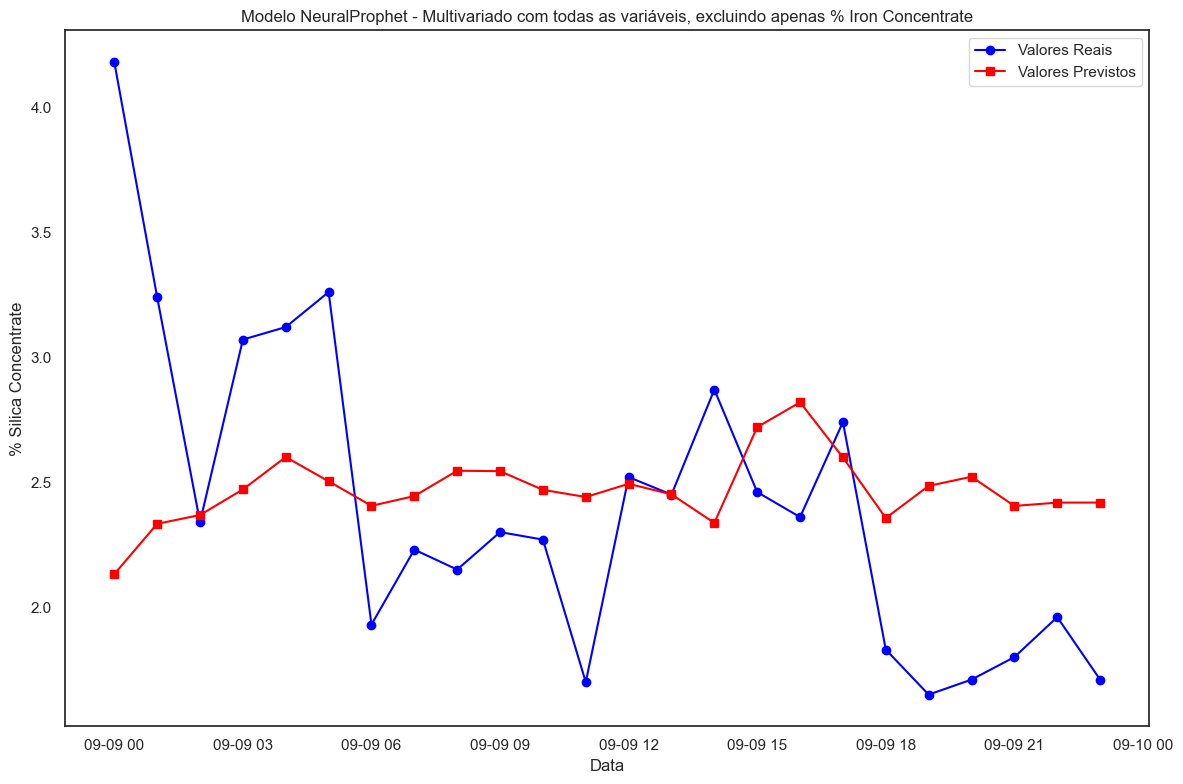

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker='o', color="blue")
plt.plot(y_pred.ds, y_pred.yhat1.values, label="Valores Previstos", marker='s', color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo NeuralProphet - Multivariado com todas as variáveis, excluindo apenas % Iron Concentrate")
plt.legend()

plt.tight_layout()

## **Modelo NeuralProphet - Multivariado com variáveis selecionadas, excluindo apenas `% Iron Concentrate`**

### **Ajuste dos hiperparâmetros com Optuna**

In [32]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['off', 'linear', 'discontinuous'])
    n_forecasts = trial.suggest_int('n_forecasts', 1, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)

    # Instaciando o modelo
    m = NeuralProphet(growth=growth, n_forecasts=n_forecasts, learning_rate=learning_rate)
    m.add_future_regressor("Amina Flow")
    m.add_future_regressor("Ore Pulp pH")
    m.add_future_regressor("Flotation Column 01 Air Flow")
    m.add_future_regressor("Flotation Column 02 Air Flow")
    m.add_future_regressor("Flotation Column 03 Air Flow")
    m.add_future_regressor("Flotation Column 04 Level")
    m.add_future_regressor("Flotation Column 05 Level")
    m.add_future_regressor("Flotation Column 06 Level")
    m.add_future_regressor("Flotation Column 07 Level")

    # Treinando o modelo
    m.fit(treino.drop(treino.index[-24:]).loc[:, ["ds", "Amina Flow", "Ore Pulp pH", 
                                                  "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                                  "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level", 
                                                  "y"]], freq="h")

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True).loc[:, ["ds", "Amina Flow", "Ore Pulp pH", 
                                                  "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                                  "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level", 
                                                  "y"]]
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat1.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [33]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 15:15:58,417] A new study created in memory with name: no-name-7d53378a-246d-4e3c-9916-8564b10d1195


Epoch 70: 100%|█| 70/70 [00:00<00:00, 230.34it/s, loss=0.0663, v_num=1684, MAE=0.778, RMSE=1.010, Loss=0.0663, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.67it/s]

[I 2024-10-19 15:16:20,487] Trial 0 finished with value: 42.99267579392459 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.1468412152280313}. Best is trial 0 with value: 42.99267579392459.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.75it/s, loss=0.0677, v_num=1685, MAE=0.762, RMSE=0.998, Loss=0.0656, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 217.94it/s]

[I 2024-10-19 15:16:41,727] Trial 1 finished with value: 34.6674458051713 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5388628523299566}. Best is trial 1 with value: 34.6674458051713.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 225.22it/s, loss=0.0658, v_num=1686, MAE=0.778, RMSE=1.010, Loss=0.0662, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.81it/s]

[I 2024-10-19 15:17:03,657] Trial 2 finished with value: 45.39589506655239 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.02748485443860637}. Best is trial 1 with value: 34.6674458051713.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 265.27it/s, loss=0.0716, v_num=1687, MAE=0.808, RMSE=1.040, Loss=0.0693, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.75it/s]

[I 2024-10-19 15:17:22,691] Trial 3 finished with value: 40.20733978771854 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.1981816789359703}. Best is trial 1 with value: 34.6674458051713.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 227.10it/s, loss=0.0675, v_num=1688, MAE=0.781, RMSE=1.010, Loss=0.0671, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.96it/s]

[I 2024-10-19 15:17:44,370] Trial 4 finished with value: 46.741622583701 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8764015133808087}. Best is trial 1 with value: 34.6674458051713.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.81it/s, loss=0.0708, v_num=1689, MAE=0.825, RMSE=1.050, Loss=0.0713, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.72it/s]

[I 2024-10-19 15:18:03,500] Trial 5 finished with value: 28.38917540530118 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8781546891790702}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 240.17it/s, loss=0.0665, v_num=1690, MAE=0.766, RMSE=1.000, Loss=0.0657, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.98it/s]

[I 2024-10-19 15:18:24,557] Trial 6 finished with value: 33.116058175733116 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6919079262390783}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 241.58it/s, loss=0.0659, v_num=1691, MAE=0.766, RMSE=1.000, Loss=0.066, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.73it/s]

[I 2024-10-19 15:18:45,598] Trial 7 finished with value: 42.78576801465726 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.750169300513473}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.94it/s, loss=0.0711, v_num=1692, MAE=0.811, RMSE=1.040, Loss=0.0698, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.74it/s]

[I 2024-10-19 15:19:04,804] Trial 8 finished with value: 36.97444674130161 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.10331568397698426}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 217.17it/s, loss=0.0665, v_num=1693, MAE=0.773, RMSE=1.000, Loss=0.0659, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.17it/s]

[I 2024-10-19 15:19:29,458] Trial 9 finished with value: 45.684135214879376 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.13011556926106585}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 261.86it/s, loss=0.0677, v_num=1694, MAE=0.824, RMSE=1.060, Loss=0.0717, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.29it/s]

[I 2024-10-19 15:19:50,037] Trial 10 finished with value: 35.49963283012902 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.9671985624260364}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 221.08it/s, loss=0.0645, v_num=1695, MAE=0.769, RMSE=1.010, Loss=0.0663, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.71it/s]

[I 2024-10-19 15:20:12,330] Trial 11 finished with value: 48.96324227328218 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.671532106792692}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 209.60it/s, loss=0.0657, v_num=1696, MAE=0.760, RMSE=0.996, Loss=0.065, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.87it/s]

[I 2024-10-19 15:20:34,783] Trial 12 finished with value: 44.55520978632641 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.4106052063451816}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.03it/s, loss=0.0669, v_num=1697, MAE=0.817, RMSE=1.050, Loss=0.0708, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 229.96it/s]

[I 2024-10-19 15:20:54,983] Trial 13 finished with value: 41.75900381943565 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.7623036193780893}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 228.73it/s, loss=0.0698, v_num=1698, MAE=0.762, RMSE=0.994, Loss=0.065, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.20it/s]

[I 2024-10-19 15:21:17,207] Trial 14 finished with value: 40.32296215606356 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5509033172990179}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 246.81it/s, loss=0.069, v_num=1699, MAE=0.819, RMSE=1.050, Loss=0.0708, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.24it/s]

[I 2024-10-19 15:21:37,946] Trial 15 finished with value: 46.224724697441815 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.984615370700596}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 255.03it/s, loss=0.0702, v_num=1700, MAE=0.811, RMSE=1.040, Loss=0.0699, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.50it/s]

[I 2024-10-19 15:21:57,764] Trial 16 finished with value: 39.52372048899897 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.39042260680219204}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 227.31it/s, loss=0.0669, v_num=1701, MAE=0.771, RMSE=1.010, Loss=0.0668, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.83it/s]

[I 2024-10-19 15:22:20,228] Trial 17 finished with value: 49.01299814069055 and parameters: {'growth': 'discontinuous', 'n_forecasts': 2, 'learning_rate': 0.8309293607842554}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 243.18it/s, loss=0.0654, v_num=1702, MAE=0.810, RMSE=1.040, Loss=0.0698, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.10it/s]

[I 2024-10-19 15:22:40,433] Trial 18 finished with value: 33.909065742489304 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.6662849327827818}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 200.95it/s, loss=0.0678, v_num=1703, MAE=0.765, RMSE=1.000, Loss=0.0657, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.68it/s]

[I 2024-10-19 15:23:02,572] Trial 19 finished with value: 39.789538148867926 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.63807549900181}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 226.42it/s, loss=0.0698, v_num=1704, MAE=0.768, RMSE=1.010, Loss=0.0664, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.60it/s]

[I 2024-10-19 15:23:24,972] Trial 20 finished with value: 42.682043554604256 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.8842877288709861}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 211.67it/s, loss=0.0753, v_num=1705, MAE=0.820, RMSE=1.050, Loss=0.0709, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.86it/s]

[I 2024-10-19 15:23:45,348] Trial 21 finished with value: 32.42910074300269 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.6791301589775163}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 255.49it/s, loss=0.0691, v_num=1706, MAE=0.817, RMSE=1.050, Loss=0.0705, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.12it/s]

[I 2024-10-19 15:24:06,086] Trial 22 finished with value: 35.62087339094851 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.7642764121268586}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 252.67it/s, loss=0.073, v_num=1707, MAE=0.817, RMSE=1.050, Loss=0.0706, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.45it/s]

[I 2024-10-19 15:24:26,655] Trial 23 finished with value: 43.13558288156689 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.6044354595536107}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.07it/s, loss=0.0702, v_num=1708, MAE=0.810, RMSE=1.040, Loss=0.0692, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.37it/s]

[I 2024-10-19 15:24:46,583] Trial 24 finished with value: 38.574523224677975 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.40216995454659943}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.26it/s, loss=0.0689, v_num=1709, MAE=0.810, RMSE=1.040, Loss=0.0695, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.86it/s]

[I 2024-10-19 15:25:05,565] Trial 25 finished with value: 38.19062352035399 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.4802711827951001}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 261.45it/s, loss=0.0703, v_num=1710, MAE=0.819, RMSE=1.050, Loss=0.0709, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.77it/s]

[I 2024-10-19 15:25:24,518] Trial 26 finished with value: 30.221699607225844 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.8222178718164188}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 267.08it/s, loss=0.0787, v_num=1711, MAE=0.827, RMSE=1.060, Loss=0.0717, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.86it/s]

[I 2024-10-19 15:25:43,553] Trial 27 finished with value: 41.08154662176117 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.9005805590346811}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 252.64it/s, loss=0.0747, v_num=1712, MAE=0.815, RMSE=1.050, Loss=0.0706, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.89it/s]

[I 2024-10-19 15:26:02,487] Trial 28 finished with value: 38.673455036247965 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.8174010459528623}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 234.33it/s, loss=0.0745, v_num=1713, MAE=0.786, RMSE=1.020, Loss=0.0676, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.81it/s]

[I 2024-10-19 15:26:24,353] Trial 29 finished with value: 47.21282447652997 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.9298757414531157}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 266.71it/s, loss=0.0751, v_num=1714, MAE=0.817, RMSE=1.050, Loss=0.0707, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.54it/s]

[I 2024-10-19 15:26:43,486] Trial 30 finished with value: 37.940950300667566 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.814309595561683}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 266.13it/s, loss=0.071, v_num=1715, MAE=0.819, RMSE=1.050, Loss=0.0708, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.04it/s]

[I 2024-10-19 15:27:02,376] Trial 31 finished with value: 43.088194409845165 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.716656617130736}. Best is trial 5 with value: 28.38917540530118.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 267.80it/s, loss=0.0721, v_num=1716, MAE=0.818, RMSE=1.050, Loss=0.0711, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.54it/s]

[I 2024-10-19 15:27:21,167] Trial 32 finished with value: 28.205051816433663 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.5894497826923997}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 271.13it/s, loss=0.0705, v_num=1717, MAE=0.814, RMSE=1.040, Loss=0.0701, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.98it/s]

[I 2024-10-19 15:27:40,813] Trial 33 finished with value: 36.70665804988474 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.5725048110348608}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 268.06it/s, loss=0.0728, v_num=1718, MAE=0.812, RMSE=1.040, Loss=0.0701, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.65it/s]

[I 2024-10-19 15:27:59,575] Trial 34 finished with value: 46.82240481564768 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.48869964206425853}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 271.09it/s, loss=0.0701, v_num=1719, MAE=0.808, RMSE=1.040, Loss=0.0695, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.76it/s]

[I 2024-10-19 15:28:18,494] Trial 35 finished with value: 36.993392673744694 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.6020191259216418}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 219.32it/s, loss=0.0633, v_num=1720, MAE=0.773, RMSE=1.010, Loss=0.0661, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.38it/s]

[I 2024-10-19 15:28:40,151] Trial 36 finished with value: 44.34889742827347 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.25152357573575923}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 270.10it/s, loss=0.0706, v_num=1721, MAE=0.817, RMSE=1.050, Loss=0.0708, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.57it/s]

[I 2024-10-19 15:28:58,988] Trial 37 finished with value: 42.66190776301242 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.8417736293250881}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 259.14it/s, loss=0.0663, v_num=1722, MAE=0.809, RMSE=1.040, Loss=0.0697, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.49it/s]

[I 2024-10-19 15:29:18,596] Trial 38 finished with value: 35.545937089229106 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.7223114510571823}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 149.40it/s, loss=0.0675, v_num=1723, MAE=0.787, RMSE=1.020, Loss=0.0679, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.23it/s]

[I 2024-10-19 15:29:40,861] Trial 39 finished with value: 43.254706202567725 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.7788072080461012}. Best is trial 32 with value: 28.205051816433663.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 263.65it/s, loss=0.068, v_num=1724, MAE=0.816, RMSE=1.050, Loss=0.0706, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.05it/s]

[I 2024-10-19 15:29:59,673] Trial 40 finished with value: 27.594376612184895 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.5230224098693883}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 264.55it/s, loss=0.0715, v_num=1725, MAE=0.818, RMSE=1.050, Loss=0.0708, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.80it/s]

[I 2024-10-19 15:30:18,874] Trial 41 finished with value: 33.03036816098419 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.4608519661045953}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 258.42it/s, loss=0.0667, v_num=1726, MAE=0.810, RMSE=1.040, Loss=0.0695, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.20it/s]

[I 2024-10-19 15:30:38,557] Trial 42 finished with value: 39.12396283627423 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.28977899676561997}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 270.21it/s, loss=0.0685, v_num=1727, MAE=0.816, RMSE=1.040, Loss=0.0701, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 217.69it/s]

[I 2024-10-19 15:30:57,778] Trial 43 finished with value: 32.20457637192221 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.525233748025202}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 261.73it/s, loss=0.0746, v_num=1728, MAE=0.815, RMSE=1.050, Loss=0.0703, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 241.64it/s]

[I 2024-10-19 15:31:17,382] Trial 44 finished with value: 45.031845532638286 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.5352117865536278}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 271.64it/s, loss=0.0717, v_num=1729, MAE=0.810, RMSE=1.040, Loss=0.0699, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 255.28it/s]

[I 2024-10-19 15:31:36,447] Trial 45 finished with value: 37.677946324214744 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.44887007836493203}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 271.37it/s, loss=0.0706, v_num=1730, MAE=0.814, RMSE=1.040, Loss=0.0701, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.96it/s]

[I 2024-10-19 15:31:55,261] Trial 46 finished with value: 39.12771584758944 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.34539170369371375}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 232.99it/s, loss=0.0673, v_num=1731, MAE=0.785, RMSE=1.020, Loss=0.067, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 231.08it/s]

[I 2024-10-19 15:32:17,027] Trial 47 finished with value: 44.841683017977644 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.5301991517112237}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 262.97it/s, loss=0.0647, v_num=1732, MAE=0.815, RMSE=1.040, Loss=0.0707, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 282.86it/s]

[I 2024-10-19 15:32:35,856] Trial 48 finished with value: 33.448579619386834 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.9363538690078691}. Best is trial 40 with value: 27.594376612184895.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 269.32it/s, loss=0.0741, v_num=1733, MAE=0.811, RMSE=1.050, Loss=0.0702, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.74it/s]

[I 2024-10-19 15:32:54,680] Trial 49 finished with value: 40.57974055500797 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.33542527558989854}. Best is trial 40 with value: 27.594376612184895.


In [34]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 27.594376612184895
Melhores parâmetros: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.5230224098693883}


### **Treinando o modelo com os hiperparâmetros ajustados**

In [35]:
m = NeuralProphet(
    growth=melhores_parametros['growth'],
    n_forecasts=melhores_parametros['n_forecasts'],
    learning_rate=melhores_parametros['learning_rate']
)

m.add_future_regressor("Amina Flow")
m.add_future_regressor("Ore Pulp pH")
m.add_future_regressor("Flotation Column 01 Air Flow")
m.add_future_regressor("Flotation Column 02 Air Flow")
m.add_future_regressor("Flotation Column 03 Air Flow")
m.add_future_regressor("Flotation Column 04 Level")
m.add_future_regressor("Flotation Column 05 Level")
m.add_future_regressor("Flotation Column 06 Level")
m.add_future_regressor("Flotation Column 07 Level")

m.fit(treino.loc[:, ["ds", "Amina Flow", "Ore Pulp pH",
                     "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                     "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level",
                     "y"]], freq='h')

Epoch 70: 100%|█| 70/70 [00:00<00:00, 264.24it/s, loss=0.0689, v_num=1734, MAE=0.812, RMSE=1.040, Loss=0.070, RegLoss=0


,MAE,RMSE,Loss,RegLoss,epoch
0,3.017471,3.623029,0.457030,0.0,0
1,1.346847,1.691084,0.152147,0.0,1
2,1.104157,1.397435,0.113029,0.0,2
3,0.983711,1.246764,0.095212,0.0,3
4,0.979642,1.231982,0.095262,0.0,4
...,...,...,...,...,...
65,0.821718,1.049374,0.071199,0.0,65
66,0.812866,1.045868,0.070226,0.0,66
67,0.808581,1.044245,0.070014,0.0,67
68,0.811199,1.042313,0.070084,0.0,68


### **Avaliando o modelo**

In [36]:
# Previsões
y_pred = m.predict(teste.loc[:, ["ds", "Amina Flow", "Ore Pulp pH",
                                 "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow",
                                 "Flotation Column 04 Level", "Flotation Column 05 Level", "Flotation Column 06 Level","Flotation Column 07 Level",
                                 "y"]])

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.12it/s]


In [37]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat1.values)

{'RMSE': 0.722751346438794,
 'MAE': 0.47713897585868836,
 'MAPE': 17.17096849244762}

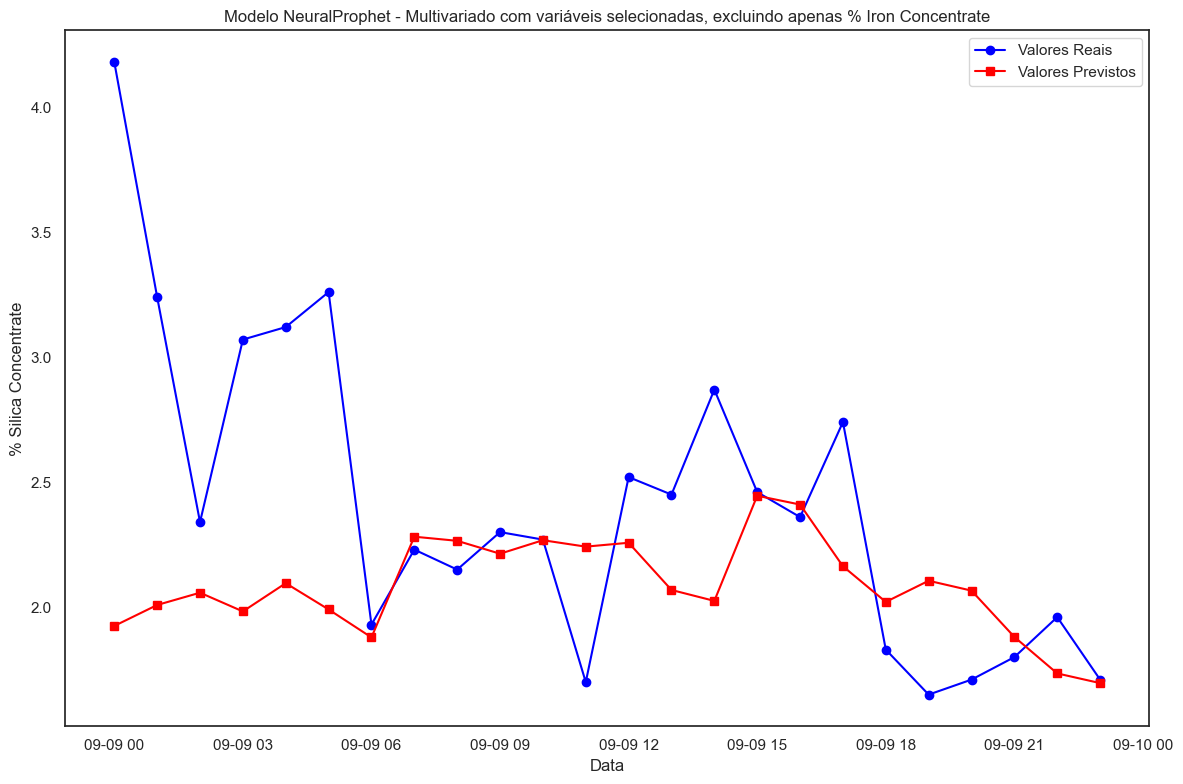

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker='o', color="blue")
plt.plot(y_pred.ds, y_pred.yhat1.values, label="Valores Previstos", marker='s', color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo NeuralProphet - Multivariado com variáveis selecionadas, excluindo apenas % Iron Concentrate")
plt.legend()

plt.tight_layout()

## **Modelo NeuralProphet - Univariado**

### **Ajuste dos hiperparâmetros com Optuna**

In [39]:
def objective(trial):
    growth = trial.suggest_categorical('growth', ['off', 'linear', 'discontinuous'])
    n_forecasts = trial.suggest_int('n_forecasts', 1, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)

    # Instaciando o modelo
    m = NeuralProphet(growth=growth, n_forecasts=n_forecasts, learning_rate=learning_rate)

    # Treinando o modelo
    m.fit(treino.drop(treino.index[-24:]).loc[:, ["ds", "y"]], freq="h")

    # Fazendo previsões
    val = treino[-24:].reset_index(drop=True).loc[:, ["ds", "y"]]
    previsoes = m.predict(val)

    # Calculado o MAPE
    y_true = val.y.values
    y_pred = previsoes.yhat1.values
    mape = (np.mean(np.true_divide(np.abs(y_true-y_pred), y_true)))*100

    return mape

In [40]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-19 15:33:14,218] A new study created in memory with name: no-name-6dcbeb85-bce1-4a3b-b4b6-c82a35785df9


Epoch 70: 100%|█| 70/70 [00:00<00:00, 236.16it/s, loss=0.0743, v_num=1735, MAE=0.797, RMSE=1.040, Loss=0.070, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.19it/s]

[I 2024-10-19 15:33:34,737] Trial 0 finished with value: 45.90718450239359 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.1468412152280313}. Best is trial 0 with value: 45.90718450239359.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 252.00it/s, loss=0.0673, v_num=1736, MAE=0.783, RMSE=1.030, Loss=0.0693, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 293.45it/s]

[I 2024-10-19 15:33:54,430] Trial 1 finished with value: 50.88110358545179 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.5388628523299566}. Best is trial 0 with value: 45.90718450239359.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 244.74it/s, loss=0.0712, v_num=1737, MAE=0.802, RMSE=1.040, Loss=0.070, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.49it/s]

[I 2024-10-19 15:34:14,997] Trial 2 finished with value: 46.231271299509345 and parameters: {'growth': 'linear', 'n_forecasts': 6, 'learning_rate': 0.02748485443860637}. Best is trial 0 with value: 45.90718450239359.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 285.62it/s, loss=0.0778, v_num=1738, MAE=0.868, RMSE=1.110, Loss=0.0777, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 229.56it/s]

[I 2024-10-19 15:34:32,498] Trial 3 finished with value: 32.21365213725042 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.1981816789359703}. Best is trial 3 with value: 32.21365213725042.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 245.54it/s, loss=0.0722, v_num=1739, MAE=0.805, RMSE=1.050, Loss=0.0711, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.21it/s]

[I 2024-10-19 15:34:53,243] Trial 4 finished with value: 44.40164122422267 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.8764015133808087}. Best is trial 3 with value: 32.21365213725042.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 288.88it/s, loss=0.0836, v_num=1740, MAE=0.885, RMSE=1.140, Loss=0.0808, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 281.23it/s]

[I 2024-10-19 15:35:11,010] Trial 5 finished with value: 28.79277618388565 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.8781546891790702}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 249.08it/s, loss=0.0717, v_num=1741, MAE=0.782, RMSE=1.030, Loss=0.0694, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.19it/s]

[I 2024-10-19 15:35:30,751] Trial 6 finished with value: 51.1325340089262 and parameters: {'growth': 'discontinuous', 'n_forecasts': 4, 'learning_rate': 0.6919079262390783}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 251.74it/s, loss=0.0676, v_num=1742, MAE=0.787, RMSE=1.030, Loss=0.0698, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.09it/s]

[I 2024-10-19 15:35:50,668] Trial 7 finished with value: 49.709430520671674 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.750169300513473}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 279.44it/s, loss=0.0724, v_num=1743, MAE=0.868, RMSE=1.110, Loss=0.0776, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 242.29it/s]

[I 2024-10-19 15:36:08,487] Trial 8 finished with value: 31.73190099853949 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.10331568397698426}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 250.04it/s, loss=0.0724, v_num=1744, MAE=0.793, RMSE=1.040, Loss=0.0699, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.11it/s]

[I 2024-10-19 15:36:28,931] Trial 9 finished with value: 47.83126224956629 and parameters: {'growth': 'linear', 'n_forecasts': 2, 'learning_rate': 0.13011556926106585}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 287.20it/s, loss=0.0795, v_num=1745, MAE=0.884, RMSE=1.130, Loss=0.080, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 298.85it/s]

[I 2024-10-19 15:36:46,970] Trial 10 finished with value: 35.552541173853804 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.9671985624260364}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 277.94it/s, loss=0.0762, v_num=1746, MAE=0.878, RMSE=1.120, Loss=0.0791, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 263.41it/s]

[I 2024-10-19 15:37:04,701] Trial 11 finished with value: 29.99943174296783 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.3866549973028639}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 280.72it/s, loss=0.0832, v_num=1747, MAE=0.875, RMSE=1.120, Loss=0.0785, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.82it/s]

[I 2024-10-19 15:37:22,464] Trial 12 finished with value: 34.15532238177138 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.3482636967170028}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 289.99it/s, loss=0.0809, v_num=1748, MAE=0.872, RMSE=1.120, Loss=0.0784, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 268.71it/s]

[I 2024-10-19 15:37:40,330] Trial 13 finished with value: 30.895122215081845 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.4500652782965935}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 287.37it/s, loss=0.0832, v_num=1749, MAE=0.879, RMSE=1.120, Loss=0.0789, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 238.19it/s]

[I 2024-10-19 15:37:58,066] Trial 14 finished with value: 34.01820960432826 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.6095567987588851}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 284.11it/s, loss=0.0777, v_num=1750, MAE=0.872, RMSE=1.120, Loss=0.0781, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.17it/s]

[I 2024-10-19 15:38:15,975] Trial 15 finished with value: 30.5868266102463 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.36148892106710895}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 270.96it/s, loss=0.077, v_num=1751, MAE=0.871, RMSE=1.110, Loss=0.0777, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 230.38it/s]

[I 2024-10-19 15:38:33,958] Trial 16 finished with value: 30.906968626970126 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.29133916220011247}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 277.14it/s, loss=0.0746, v_num=1752, MAE=0.875, RMSE=1.120, Loss=0.0786, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 238.15it/s]

[I 2024-10-19 15:38:52,014] Trial 17 finished with value: 34.98491706087718 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.8061921693558807}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 289.78it/s, loss=0.0822, v_num=1753, MAE=0.880, RMSE=1.130, Loss=0.0796, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 273.67it/s]

[I 2024-10-19 15:39:09,991] Trial 18 finished with value: 31.412563272516934 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.5031026866539762}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 256.62it/s, loss=0.0739, v_num=1754, MAE=0.790, RMSE=1.030, Loss=0.0701, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 231.87it/s]

[I 2024-10-19 15:39:29,851] Trial 19 finished with value: 39.154786783369076 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.9753101329971224}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 280.39it/s, loss=0.0796, v_num=1755, MAE=0.875, RMSE=1.130, Loss=0.0789, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 230.19it/s]

[I 2024-10-19 15:39:48,071] Trial 20 finished with value: 30.074714960231436 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.6146405228638104}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 286.90it/s, loss=0.0789, v_num=1756, MAE=0.882, RMSE=1.130, Loss=0.080, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 274.33it/s]

[I 2024-10-19 15:40:06,236] Trial 21 finished with value: 30.981819450362792 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.6329938237592279}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 280.14it/s, loss=0.0828, v_num=1757, MAE=0.882, RMSE=1.130, Loss=0.0797, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.77it/s]

[I 2024-10-19 15:40:24,591] Trial 22 finished with value: 34.740179978897736 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.8379868050256732}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 285.09it/s, loss=0.0739, v_num=1758, MAE=0.870, RMSE=1.110, Loss=0.0778, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 314.60it/s]

[I 2024-10-19 15:40:42,819] Trial 23 finished with value: 30.75611745892562 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.42932883406948}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 288.61it/s, loss=0.0798, v_num=1759, MAE=0.874, RMSE=1.120, Loss=0.0788, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 266.56it/s]

[I 2024-10-19 15:41:00,567] Trial 24 finished with value: 36.45346854767437 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.5929232695022258}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 283.65it/s, loss=0.0803, v_num=1760, MAE=0.875, RMSE=1.120, Loss=0.0787, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.54it/s]

[I 2024-10-19 15:41:18,515] Trial 25 finished with value: 37.63928562770869 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.7350197489692186}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 272.02it/s, loss=0.077, v_num=1761, MAE=0.868, RMSE=1.110, Loss=0.0777, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 303.71it/s]

[I 2024-10-19 15:41:36,207] Trial 26 finished with value: 30.583308211725956 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.247762633743115}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 268.54it/s, loss=0.0843, v_num=1762, MAE=0.883, RMSE=1.130, Loss=0.0801, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 405.13it/s]

[I 2024-10-19 15:41:54,063] Trial 27 finished with value: 35.6923940210089 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.9126679848808394}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 251.84it/s, loss=0.063, v_num=1763, MAE=0.776, RMSE=1.020, Loss=0.0683, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.51it/s]

[I 2024-10-19 15:42:13,902] Trial 28 finished with value: 39.56674517446383 and parameters: {'growth': 'discontinuous', 'n_forecasts': 1, 'learning_rate': 0.4059302877724966}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 231.32it/s, loss=0.0671, v_num=1764, MAE=0.800, RMSE=1.040, Loss=0.0706, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 238.87it/s]

[I 2024-10-19 15:42:34,569] Trial 29 finished with value: 40.10523169081107 and parameters: {'growth': 'linear', 'n_forecasts': 4, 'learning_rate': 0.676346059047172}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 246.08it/s, loss=0.069, v_num=1765, MAE=0.802, RMSE=1.050, Loss=0.0705, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.58it/s]

[I 2024-10-19 15:42:54,968] Trial 30 finished with value: 41.84237985655372 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.5433751751766779}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 254.59it/s, loss=0.0798, v_num=1766, MAE=0.872, RMSE=1.120, Loss=0.0781, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.56it/s]

[I 2024-10-19 15:43:12,608] Trial 31 finished with value: 30.533528099545993 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.23130234381373546}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 295.62it/s, loss=0.0779, v_num=1767, MAE=0.874, RMSE=1.120, Loss=0.0785, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 308.06it/s]

[I 2024-10-19 15:43:30,163] Trial 32 finished with value: 32.6719590312052 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.2765289448646989}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 286.07it/s, loss=0.0792, v_num=1768, MAE=0.868, RMSE=1.120, Loss=0.078, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.87it/s]

[I 2024-10-19 15:43:47,923] Trial 33 finished with value: 33.14943996733692 and parameters: {'growth': 'off', 'n_forecasts': 2, 'learning_rate': 0.21912721154412385}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 288.57it/s, loss=0.503, v_num=1769, MAE=3.340, RMSE=3.930, Loss=0.500, RegLoss=0.
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 263.88it/s]

[I 2024-10-19 15:44:05,471] Trial 34 finished with value: 152.17409939588694 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.00019721876729253407}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 282.50it/s, loss=0.0802, v_num=1770, MAE=0.872, RMSE=1.120, Loss=0.0783, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 307.95it/s]

[I 2024-10-19 15:44:23,122] Trial 35 finished with value: 30.468526770934158 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.3167816968060823}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 246.97it/s, loss=0.068, v_num=1771, MAE=0.781, RMSE=1.030, Loss=0.0686, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.20it/s]

[I 2024-10-19 15:44:43,546] Trial 36 finished with value: 47.53909898203232 and parameters: {'growth': 'discontinuous', 'n_forecasts': 3, 'learning_rate': 0.3528530949969036}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 233.80it/s, loss=0.0694, v_num=1772, MAE=0.802, RMSE=1.050, Loss=0.0706, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 308.68it/s]

[I 2024-10-19 15:45:04,338] Trial 37 finished with value: 47.074678588254244 and parameters: {'growth': 'linear', 'n_forecasts': 3, 'learning_rate': 0.486626824471463}. Best is trial 5 with value: 28.79277618388565.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 278.10it/s, loss=0.0744, v_num=1773, MAE=0.876, RMSE=1.130, Loss=0.079, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 281.53it/s]

[I 2024-10-19 15:45:22,116] Trial 38 finished with value: 25.565486801328973 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.7618053811925817}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 255.41it/s, loss=0.07, v_num=1774, MAE=0.782, RMSE=1.040, Loss=0.0696, RegLoss=0.
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 299.29it/s]

[I 2024-10-19 15:45:42,456] Trial 39 finished with value: 43.515045061982086 and parameters: {'growth': 'discontinuous', 'n_forecasts': 5, 'learning_rate': 0.7330495583968665}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 268.32it/s, loss=0.0754, v_num=1775, MAE=0.876, RMSE=1.120, Loss=0.0789, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 369.22it/s]

[I 2024-10-19 15:46:00,372] Trial 40 finished with value: 30.682935426989577 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.8074741329880265}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 286.99it/s, loss=0.0813, v_num=1776, MAE=0.881, RMSE=1.130, Loss=0.0802, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 233.50it/s]

[I 2024-10-19 15:46:18,165] Trial 41 finished with value: 31.797717942826694 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.916426479821}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 279.37it/s, loss=0.0742, v_num=1777, MAE=0.872, RMSE=1.120, Loss=0.0781, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 322.17it/s]

[I 2024-10-19 15:46:36,050] Trial 42 finished with value: 36.52890633114008 and parameters: {'growth': 'off', 'n_forecasts': 5, 'learning_rate': 0.5517052104832593}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 289.39it/s, loss=0.0772, v_num=1778, MAE=0.872, RMSE=1.120, Loss=0.0782, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 269.33it/s]

[I 2024-10-19 15:46:53,873] Trial 43 finished with value: 31.08404638495184 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.1704818240181751}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 257.52it/s, loss=0.0817, v_num=1779, MAE=0.879, RMSE=1.130, Loss=0.0796, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.30it/s]

[I 2024-10-19 15:47:11,667] Trial 44 finished with value: 32.110596587870106 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.7804864063572378}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 247.64it/s, loss=0.0659, v_num=1780, MAE=0.801, RMSE=1.040, Loss=0.0706, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.36it/s]

[I 2024-10-19 15:47:32,218] Trial 45 finished with value: 47.75609572340813 and parameters: {'growth': 'linear', 'n_forecasts': 5, 'learning_rate': 0.6764093554617993}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 287.66it/s, loss=0.0804, v_num=1781, MAE=0.874, RMSE=1.120, Loss=0.0786, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 269.97it/s]

[I 2024-10-19 15:47:49,973] Trial 46 finished with value: 32.206875655830565 and parameters: {'growth': 'off', 'n_forecasts': 1, 'learning_rate': 0.301475672115895}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 278.27it/s, loss=0.084, v_num=1782, MAE=0.881, RMSE=1.130, Loss=0.0799, RegLoss=0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 242.75it/s]

[I 2024-10-19 15:48:07,672] Trial 47 finished with value: 39.857956873960944 and parameters: {'growth': 'off', 'n_forecasts': 6, 'learning_rate': 0.8732027500205531}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 285.97it/s, loss=0.0715, v_num=1783, MAE=0.870, RMSE=1.120, Loss=0.0781, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.78it/s]

[I 2024-10-19 15:48:25,278] Trial 48 finished with value: 32.357200818388534 and parameters: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.09166803686443392}. Best is trial 38 with value: 25.565486801328973.



Epoch 70: 100%|█| 70/70 [00:00<00:00, 288.62it/s, loss=0.0768, v_num=1784, MAE=0.874, RMSE=1.120, Loss=0.0782, RegLoss=
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 274.60it/s]

[I 2024-10-19 15:48:43,059] Trial 49 finished with value: 32.00735905243011 and parameters: {'growth': 'off', 'n_forecasts': 3, 'learning_rate': 0.3816264365055486}. Best is trial 38 with value: 25.565486801328973.


In [41]:
melhores_parametros = study.best_params

print(f"Melhor MAPE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MAPE: 25.565486801328973
Melhores parâmetros: {'growth': 'off', 'n_forecasts': 4, 'learning_rate': 0.7618053811925817}


### **Treinando o modelo com os hiperparâmetros ajustados**

In [42]:
m = NeuralProphet(
    growth=melhores_parametros['growth'],
    n_forecasts=melhores_parametros['n_forecasts'],
    learning_rate=melhores_parametros['learning_rate']
)

m.fit(treino.loc[:, ["ds", "y"]], freq='h')

Epoch 70: 100%|█| 70/70 [00:00<00:00, 281.29it/s, loss=0.0803, v_num=1785, MAE=0.876, RMSE=1.130, Loss=0.0793, RegLoss=


,MAE,RMSE,Loss,RegLoss,epoch
0,1.229505,1.550381,0.137646,0.0,0
1,0.969980,1.237252,0.094235,0.0,1
2,0.976666,1.241741,0.094996,0.0,2
3,1.015954,1.288510,0.101170,0.0,3
4,1.057928,1.336309,0.107861,0.0,4
...,...,...,...,...,...
65,0.876287,1.124703,0.079122,0.0,65
66,0.880829,1.128969,0.079569,0.0,66
67,0.874479,1.120452,0.078849,0.0,67
68,0.875448,1.124431,0.079029,0.0,68


### **Avaliando o modelo**

In [43]:
# Previsões
y_pred = m.predict(teste.loc[:, ["ds", "y"]])

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.01it/s]


In [44]:
# Visualizando as métricas
eval_metrics(teste.y.values, y_pred.yhat1.values)

{'RMSE': 0.6711795338383449,
 'MAE': 0.4893291050195694,
 'MAPE': 18.26476593144255}

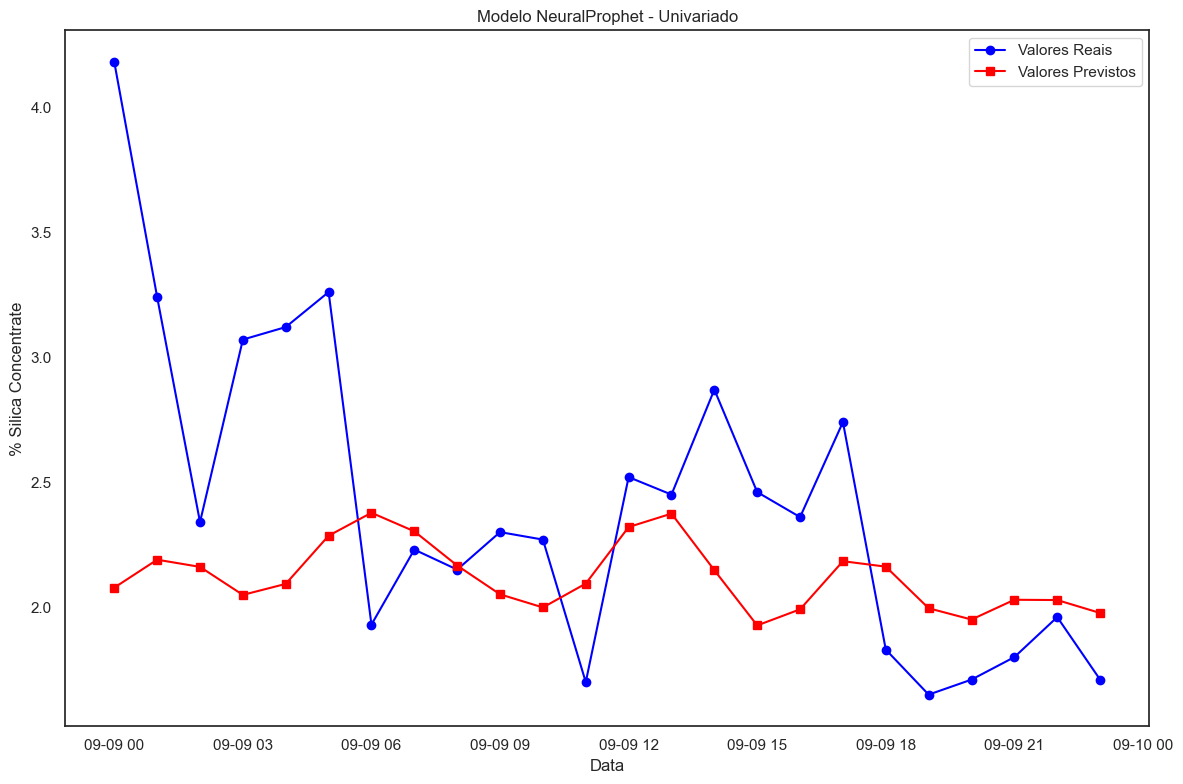

In [45]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(teste.ds, teste.y.values, label="Valores Reais", marker='o', color="blue")
plt.plot(y_pred.ds, y_pred.yhat1.values, label="Valores Previstos", marker='s', color="red")

plt.ylabel("% Silica Concentrate")
plt.xlabel("Data")
plt.title("Modelo NeuralProphet - Univariado")
plt.legend()

plt.tight_layout()